#Exercise 1: Convolutional Autoencoder#

Train a convolutional autoencoder on MNIST, study the influence of the bottleneck size and generate some images

In [0]:
import numpy as np
np.random.seed(1)
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math
from torch.autograd import Variable
from torchvision import datasets, transforms, utils
from IPython.display import display
from PIL import Image
torch.manual_seed(1)
if torch.cuda.is_available():
  torch.cuda.manual_seed_all(1)
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
# Let's define some hyper-parameters
hparams = {
    'batch_size':64,
    'num_epochs':5,
    'test_batch_size':64,
    'hidden_size':128,
    'learning_rate':1e-3,
    'log_interval':100,
}

# we select to work on GPU if it is available in the machine, otherwise
# will run on CPU
hparams['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'

**Load Dataset**

In [0]:
mnist_trainset = datasets.MNIST('data', train=True, download=True,
                                transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.1307,), (0.3081,))                        
                                ]))
mnist_testset = datasets.MNIST('data', train=False, 
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

**Split data**:
We split the data in 95% for training and 5% for validation

In [128]:
#we take the size of the trainset and after that we take 5% of dataset
tvdataset_length = len(mnist_trainset)
validationset_length = int(0.05*tvdataset_length)
#we split the dataset
[trainset,validationset]=torch.utils.data.random_split(mnist_trainset,[tvdataset_length-validationset_length,validationset_length])
print('Validation dataset is :{}%'.format(100*len(validationset)/len(mnist_trainset)))
print('Training dataset is :{}%'.format(100*len(trainset)/len(mnist_trainset)))

Validation dataset is :5.0%
Training dataset is :95.0%


**Loader data**
We load the dataset with batch size 

In [0]:
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

validation_loader = torch.utils.data.DataLoader(
    validationset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
     mnist_testset,
    batch_size=hparams['test_batch_size'], 
    shuffle=False)

## 2. Implement a convolutional autoencoder (with separate Encoder and Decoder modules). ##

**Creation of the Class Autoencoder**

**Define of the Class encoder**

In [0]:
class Encoder(nn.Module):
  def __init__(self,bottleneck):
    super().__init__()
    self.bottleneck = bottleneck
    self.conv1 = nn.Sequential( 
              nn.Conv2d(1,64,5,padding=2),
              nn.MaxPool2d(2,2),
              nn.ReLU(inplace = True),
              nn.Dropout(0.5))
    self.conv2 = nn.Sequential(
              nn.Conv2d(64,32,5,padding=2),
              nn.ReLU(inplace = True),
              nn.Dropout(0.5)
              )
    self.conv3 = nn.Sequential(
              nn.Conv2d(32,16,5,padding=2),
              nn.MaxPool2d(2,2),
              nn.ReLU(inplace = True),
              nn.Dropout(0.5),
              nn.Flatten()
    )
    self.fc = nn.Sequential(
              nn.Linear(16*7*7,self.bottleneck),
              nn.ReLU())
  def forward(self,x):
    x= self.conv1(x)
    x= self.conv2(x)
    x= self.conv3(x)
    x= self.fc(x)
    return x  

**Define of the class Decoder**

In [0]:
class Decoder(nn.Module):
  def __init__(self,bottleneck):
    super().__init__()
    self.bottleneck = bottleneck
    self.conv1 = nn.Sequential( 
          nn.ConvTranspose2d(64,32,14,stride=2),
          nn.BatchNorm2d(32),
          nn.ReLU(),
          nn.Dropout(0.5))
    self.conv2 = nn.Sequential(
          nn.ConvTranspose2d(32,1,2,stride=2),
          nn.Sigmoid())
    self.fc = nn.Sequential(
          nn.Linear(self.bottleneck,64),
          nn.ReLU())
  def forward(self,x):
    x= self.fc(x)
    x= self.conv1(x.view(x.shape[0], 64, 1,1))
    x= self.conv2(x)
    return x

**Define of the class Autoencoder**

In [0]:
class Autoencoder(nn.Module):
    def __init__(self,bottleneck):
      super().__init__()
      self.bottleneck = bottleneck
      self.encoder = Encoder(self.bottleneck)
      self.decoder = Decoder(self.bottleneck)
    def forward(self,x):
      x= self.encoder(x)
      x= self.decoder(x)
      return x

**Train the Model**

Definition of the function *train epoch*. It train the weights of the model. It computes the loss of the train and it performs the backpropagation. 

In [0]:
def train_epoch(train_loader,model,optimizer,criterion,hparams):
  model.train()
  #avg_loss_train = None
  #avg_weight = 0.1
  losses = []
  for batch_idx, data in enumerate(train_loader):
          optimizer.zero_grad()
          img, _ = data
          img = img.cuda()
          output = model(img)
          loss = criterion(output,img)
          loss.backward()
          optimizer.step()
          if batch_idx % hparams['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\n'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            #avg_loss_train = loss.item() 
          losses.append(loss.item())
  return losses

It is a generic fonction to evaluate the model it return the loss average and the MSE. 

In [0]:
def test_epoch(set_loader,model,hparams):
  model.eval()
  avg_loss_validation =0
  MSE = 0
  with torch.no_grad():
    for data in set_loader:
      img,_ = data
      img = img.cuda()
      output = model(img)
      val_loss = criterion(output,img)
      MSE += criterion_MSE(output,img)
      avg_loss_validation+= val_loss
  avg_loss_validation /= len(set_loader)
  MSE /= len(set_loader) 
  return avg_loss_validation,MSE

Fuction to compute the number of paramater 

In [0]:
def number_param(model):
  return sum(p.numel() for p in model.parameters())

###Train of the model and evalutation of it with different bottleneck###

In [0]:
dic_MSE = dict()
validation_loss_bottleneck = dict()
train_loss_bottleneck = dict()
models = dict()
for bottleneck in range(5,25,4):
  model = Autoencoder(bottleneck).cuda()
  model.to(hparams['device'])
  models[bottleneck] = model
  print('Bottleneck :{}'.format(bottleneck))
  number_param_bottleneck = number_param(model)
  print('Number param for a bottleneck of {} : {} parameters'.format(bottleneck,number_param_bottleneck))
  list_MSE_validation = []
  train_loss = []
  validation_loss = [0]
  criterion_MSE = nn.MSELoss()
  criterion = nn.MSELoss()#nn.BCELoss()
  optimizer =  optim.Adam(model.parameters(), lr=hparams['learning_rate'])
  for epoch in range(hparams['num_epochs']):
    train_loss.extend(train_epoch(train_loader,model,optimizer,criterion,hparams))
    val_loss,MSE_validation = test_epoch(validation_loader,model,hparams)
    validation_loss.append(val_loss)
    list_MSE_validation.append(MSE_validation)
    print('Train epoch [{}/{}], validation loss = {:.4f}, MSE:{:.2f}\n'.format(epoch+1, hparams['num_epochs'],val_loss,MSE_validation))
  _,test_MSE = test_epoch(test_loader,model,hparams)
  train_loss_bottleneck[bottleneck]= train_loss
  validation_loss_bottleneck[bottleneck] = validation_loss
  dic_MSE[bottleneck]= [test_MSE.item(),list_MSE_validation[-1].item(),number_param_bottleneck]

Bottleneck :5
Number param for a bottleneck of 5 : 471654 parameters
Train Epoch: 0 [0/57000 (0%)]	Loss: 0.630384

Train Epoch: 0 [200/57000 (11%)]	Loss: -1.190554

Train Epoch: 0 [400/57000 (22%)]	Loss: -2.396671

Train Epoch: 0 [600/57000 (34%)]	Loss: -3.920789

Train Epoch: 0 [800/57000 (45%)]	Loss: -5.782422

Train Epoch: 0 [1000/57000 (56%)]	Loss: -7.331224

Train Epoch: 0 [1200/57000 (67%)]	Loss: -8.716306

Train Epoch: 0 [1400/57000 (79%)]	Loss: -9.970074

Train Epoch: 0 [1600/57000 (90%)]	Loss: -11.025948

Train epoch [1/2], validation loss = -11.3592, MSE:0.66

Train Epoch: 1 [0/57000 (0%)]	Loss: -11.370235

Train Epoch: 1 [200/57000 (11%)]	Loss: -12.475941

Train Epoch: 1 [400/57000 (22%)]	Loss: -13.050211

Train Epoch: 1 [600/57000 (34%)]	Loss: -13.122763

Train Epoch: 1 [800/57000 (45%)]	Loss: -14.276472

Train Epoch: 1 [1000/57000 (56%)]	Loss: -14.674782

Train Epoch: 1 [1200/57000 (67%)]	Loss: -15.445906

Train Epoch: 1 [1400/57000 (79%)]	Loss: -15.503515

Train Epoch: 1 

Plot the Loss 

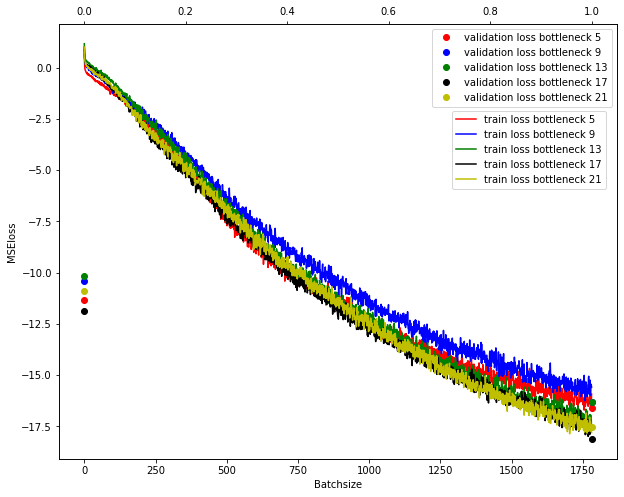

In [0]:
fig, ax1 = plt.subplots(figsize=(10,8))
plt.xlabel('Batchsize')
plt.ylabel('MSEloss')
form = ['-','o']
color = ['r','b','g','k','y']
ax2 = ax1.twiny()
i=0
for bottleneck in train_loss_bottleneck.keys():
  ax1.plot(train_loss_bottleneck.get(bottleneck),color[i]+form[0], label='train loss bottleneck {}'.format(bottleneck))
  
  ax2.plot(validation_loss_bottleneck.get(bottleneck),color[i]+form[1],label='validation loss bottleneck {}'.format(bottleneck))
  i+=1
ax1.legend(bbox_to_anchor=(0.98, 0.8), loc='upper right', borderaxespad=0.)
ax2.legend()
plt.show()

##Table of the differents MSE##

In [0]:
data = {"Bottleneck":["Test MSE","Validation MSE","number of parameters"]}
data.update(dic_MSE)
df = pd.DataFrame(data)
df = df.groupby('Bottleneck')
df.first()

,5,9,13,17,21
Bottleneck,,,,,
Test MSE,0.653558,0.655330,0.631896,0.578431,0.587001
Validation MSE,0.643902,0.646191,0.623162,0.569834,0.579055
number of parameters,471654.000000,475050.000000,478446.000000,481842.000000,485238.000000


We take the model for a bottleneck of size 17

In [0]:
bottleneck = 17
model = models[bottleneck]

Display of 5 random images and the ouput of the model

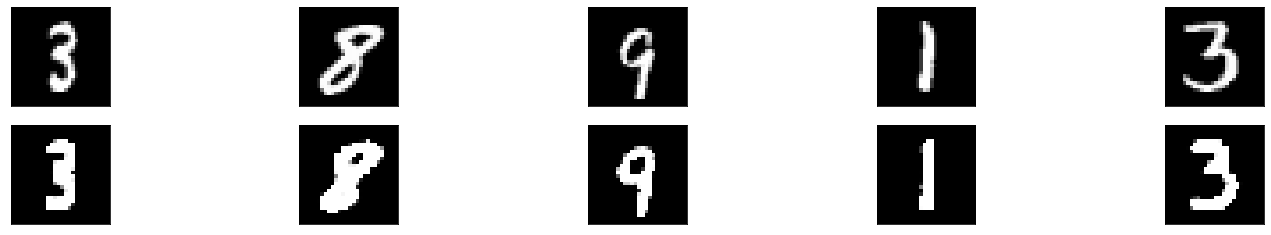

In [0]:
#take 5 random images
random_set_loader = torch.utils.data.DataLoader(
     mnist_testset,
    batch_size=5, 
    shuffle=True)
dataiter = iter(random_set_loader)
images,_ =dataiter.next()
images = images.cuda()
output = model(images)
images = images.cpu().detach().numpy()
output = output.cpu().detach().numpy()
fig, axes = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(25,4
))  
for images, row in zip([images, output],axes):
  for img,ax in zip(images,row):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

**Generate 5 new images**

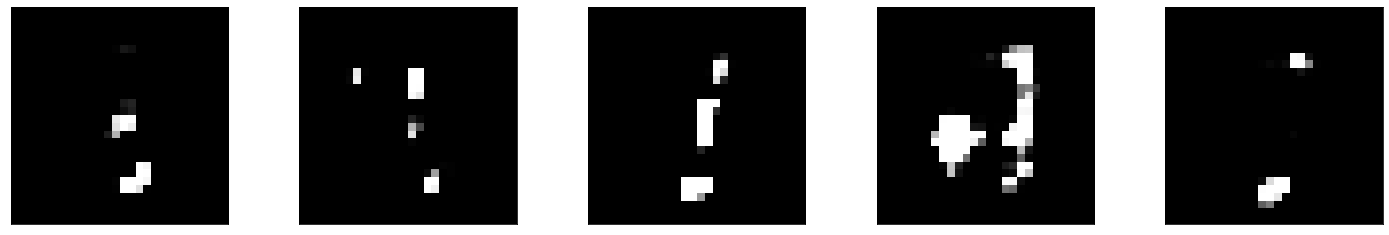

In [0]:
#for i in range(5):
nb_images = 5
rand_features = torch.randn(nb_images, bottleneck).to(hparams['device']) 
output = model.decoder(rand_features)
#Visualisation
output = output.cpu().detach().numpy()
images_width = 28
fig, axes = plt.subplots(nrows=1,ncols=5,sharex=True,sharey=True,figsize=(25,4))
decoded_images = output[:nb_images]  
for ax, img in zip(axes, decoded_images):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#Exercice 2#

We take a subset of 100 images and their associates label from the MNIST training data.

In [0]:
nb_images_subnet = 100
[trainset,_]=torch.utils.data.random_split(mnist_trainset,[nb_images_subnet,tvdataset_length-nb_images_subnet])
train_loader = torch.utils.data.DataLoader(
    trainset,
    batch_size=hparams['batch_size'], 
    shuffle=True)

We first take the layers of the encoder part of the  model autoencoder. We take the one with a bottleneck of length 15.

In [0]:
encoder_pretrain = model.encoder 
encoder_pretrain.eval()
encoder_pretrain.to(hparams['device'])

Encoder(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Flatten()
  )
  (fc): Sequential(
    (0): Linear(in_features=784, out_features=17, bias=True)
    (1): ReLU()
  )
)

We create the classification model

In [0]:
bottleneck = 17
class Classification(nn.Module):
  def __init__(self,endoder):
    super().__init__()
    self.layers = endoder
    #fully connected layers
    self.fc = nn.Sequential(
        nn.Linear(bottleneck,10),
        nn.LogSoftmax(dim=1)
    )
  def forward(self,x):
    x = self.layers(x)
    x= self.fc(x)
    return x

Training with the previous weights. 

In [0]:
def correct_predictions(predicted_batch, label_batch):
  pred = predicted_batch.argmax(dim=1, keepdim=True) # get the index of the max log-probability
  acum = pred.eq(label_batch.view_as(pred)).sum().item()
  return acum

def train_epoch(train_loader, network, optimizer, criterion, hparams):
  # Activate the train=True flag inside the model
  network.train()
  device = hparams['device']
  avg_loss = None
  avg_weight = 0.1
  for batch_idx, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)
      optimizer.zero_grad()
      output = network(data)
      loss = criterion(output, target)
      loss.backward()
      if avg_loss:
        avg_loss = avg_weight * loss.item() + (1 - avg_weight) * avg_loss
      else:
        avg_loss = loss.item()
      optimizer.step()
      if batch_idx % hparams['log_interval'] == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return avg_loss
def test_epoch(test_loader, network, hparams):
    network.eval()
    device = hparams['device']
    test_loss = 0
    acc = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = network(data)
            #test_loss += criterion(output, target,reduction='sum').item() # sum up batch loss   eduction='sum'
            # compute number of correct predictions in the batch
            acc += correct_predictions(output, target)
    # Average acc across all correct predictions batches now
    #test_loss /= len(test_loader.dataset)
    test_acc = 100. * acc / len(test_loader.dataset)
    print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
         acc, len(test_loader.dataset), test_acc,
        ))
    return test_loss, test_acc

In [0]:
def epoch(model_,optimizer_):  
    tr_losses = []
    te_losses = []
    te_accs = []
    model_.to(hparams['device'])
    optimizer = optimizer_ 
    criterion = F.nll_loss
    for epoch in range(1, hparams['num_epochs'] + 50):
      print('Epoch {}'.format(epoch))
      tr_losses.append(train_epoch(train_loader, model_, optimizer, criterion, hparams))
      te_loss, te_acc = test_epoch(test_loader, model_, hparams)
      te_losses.append(te_loss)
      te_accs.append(te_acc)   
    return te_accs

In [0]:
model_classifier = Classification(encoder_pretrain)
optimzer_pretrain = optim.RMSprop(model_classifier.parameters(), lr=hparams['learning_rate'])
accs_pretrain=epoch(model_classifier,optimzer_pretrain)

Epoch 1
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 11.295638

Test set: Accuracy: 2404/10000 (24%)

Epoch 2
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 2.127764

Test set: Accuracy: 3733/10000 (37%)

Epoch 3
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 1.711403

Test set: Accuracy: 5019/10000 (50%)

Epoch 4
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 1.682743

Test set: Accuracy: 5696/10000 (57%)

Epoch 5
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 1.388746

Test set: Accuracy: 6242/10000 (62%)

Epoch 6
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 1.210197

Test set: Accuracy: 6595/10000 (66%)

Epoch 7
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 0.976488

Test set: Accuracy: 7208/10000 (72%)

Epoch 8
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 1.037449

Test set: Accuracy: 6826/10000 (68%)

Epoch 9
Train E

Fine-tunning with the same learning rate 

In [0]:
fine_tuning_features = model.encoder
fine_tuning_model= Classification(fine_tuning_features)
optimzer_fine_tuning = optim.SGD([
                {'params': fine_tuning_model.layers.parameters()},
                {'params': fine_tuning_model.fc.parameters(), 'lr':hparams['learning_rate'] }
            ], lr=1e-6, momentum=0.9)


Train the model fine tuning with the normal learning rate

In [0]:
acc_fine_tuning =epoch(fine_tuning_model,optimzer_fine_tuning)

Epoch 1
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 12.201880

Test set: Accuracy: 590/10000 (6%)

Epoch 2
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 10.663253

Test set: Accuracy: 1801/10000 (18%)

Epoch 3
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 6.600730

Test set: Accuracy: 3054/10000 (31%)

Epoch 4
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 6.360655

Test set: Accuracy: 3529/10000 (35%)

Epoch 5
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 4.871706

Test set: Accuracy: 3493/10000 (35%)

Epoch 6
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 4.107152

Test set: Accuracy: 4125/10000 (41%)

Epoch 7
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 3.055625

Test set: Accuracy: 5387/10000 (54%)

Epoch 8
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: 3.268137

Test set: Accuracy: 6237/10000 (62%)

Epoch 9
Train Ep

Model Train from scratch

In [0]:
bottleneck = 17
networ_scratch = Classification(Encoder(17))
optimzer_scratch = optim.RMSprop(model_classifier.parameters(), lr=hparams['learning_rate'])
accs_scratch = epoch(network_scratch,optimzer_scratch)

Epoch 1
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.098724

Test set: Accuracy: 974/10000 (10%)

Epoch 2
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.098795

Test set: Accuracy: 974/10000 (10%)

Epoch 3
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.101008

Test set: Accuracy: 974/10000 (10%)

Epoch 4
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.097297

Test set: Accuracy: 974/10000 (10%)

Epoch 5
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.100301

Test set: Accuracy: 974/10000 (10%)

Epoch 6
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.100569

Test set: Accuracy: 974/10000 (10%)

Epoch 7
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.098615

Test set: Accuracy: 974/10000 (10%)

Epoch 8
Train Epoch: <function epoch at 0x7f5afac01f28> [0/100 (0%)]	Loss: -0.099151

Test set: Accuracy: 974/10000 (10%)

Epoch 9
Train Ep

Train the model from scratch

Plot all the accuracy

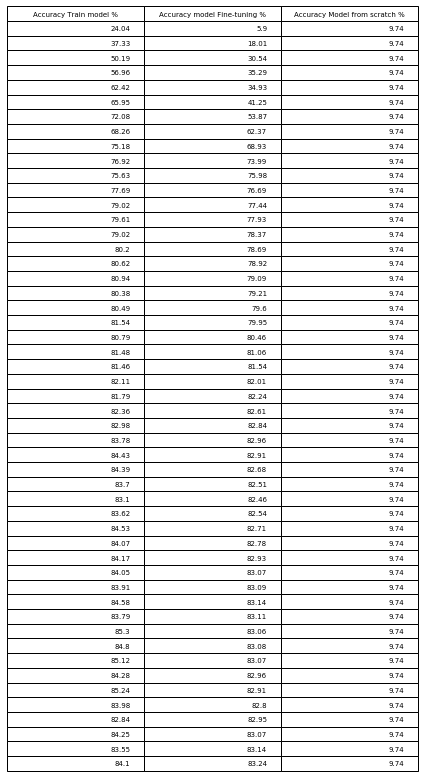

In [0]:
fig, ax = plt.subplots()
#hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
data = {'Accuracy Train model %':accs_pretrain,'Accuracy model Fine-tuning %':acc_fine_tuning,'Accuracy Model from scratch %':accs_scratch}
df = pd.DataFrame(data)
ax.table(cellText=df.values, colLabels=df.columns, loc='center')
fig.tight_layout()
plt.show()

#Exercice A#

Definition of the class VariationalAutoencoder

In [0]:
class VariationalAutoencoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.bottleneck = 40
    self.encoder = Encoder(self.bottleneck)
    self.decoder = Decoder(20)
  def reparametrize(self,mu,logvar):
    var = logvar.exp()
    sigma = var.sqrt()
    #we create the normal distribution N(0,1) with the same size of sigma and as a Float tensor
    normal = Variable(torch.cuda.FloatTensor(sigma.size()).normal_())
    return normal.mul(sigma).add(mu)
  def forward(self,x):
    x=self.encoder(x)
    #we take the 20th first parameters for the mean
    mu = x[:,:20]
    #from 20 to the end we take the the ln (log) of the variance
    logvar = x[:,20:]
    x= self.reparametrize(mu,logvar)
    x = self.decoder(x)
    return x,mu,logvar

define and Train of the model

In [53]:
model = VariationalAutoencoder().cuda()
criterion = nn.MSELoss()
optimizer =  optim.Adam(model.parameters(), lr=hparams['learning_rate'])
for epoch in range(hparams['num_epochs']+10):
    for data in train_loader:
        model.train()     
        img, _ = data
        img,_ = data
        img = img.cuda()
        # ===================forward=====================
        #kullBack Leigler divergence 
        x_hat, mu, logvar = model(img)
        NKLD = mu.pow(2).add(logvar.exp()).mul(-1).add(logvar.add(1))
        KLD = torch.sum(NKLD).mul(-0.5)
        KLD /= 128 * 784
        loss = criterion(x_hat, img) + KLD
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, hparams['num_epochs']+10, loss.data.item()))  

epoch [1/15], loss:0.6731
epoch [2/15], loss:0.6689
epoch [3/15], loss:0.6488
epoch [4/15], loss:0.6116
epoch [5/15], loss:0.6341
epoch [6/15], loss:0.6295
epoch [7/15], loss:0.6585
epoch [8/15], loss:0.5830
epoch [9/15], loss:0.6403
epoch [10/15], loss:0.6185
epoch [11/15], loss:0.6449
epoch [12/15], loss:0.6129
epoch [13/15], loss:0.6135
epoch [14/15], loss:0.5954
epoch [15/15], loss:0.6405


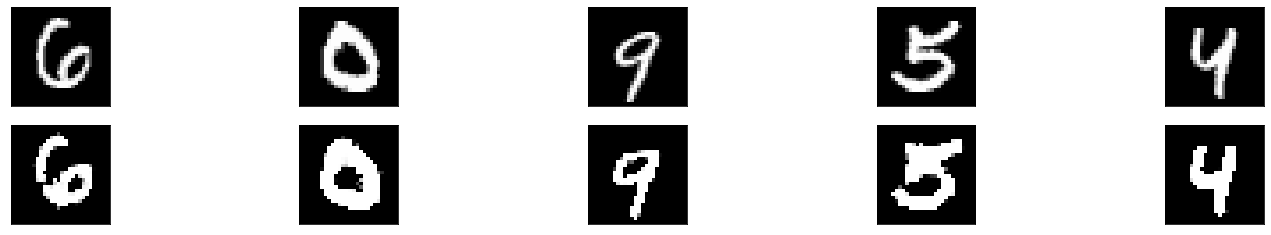

In [26]:
#take 5 random images
random_set_loader = torch.utils.data.DataLoader(
     mnist_testset,
    batch_size=5, 
    shuffle=True)
dataiter = iter(random_set_loader)
images,_ =dataiter.next()
images = images.cuda()
output,_,_ = model(images)
images = images.cpu().detach().numpy()
output = output.cpu().detach().numpy()
fig, axes = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True,figsize=(25,4
))  
for images, row in zip([images, output],axes):
  for img,ax in zip(images,row):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

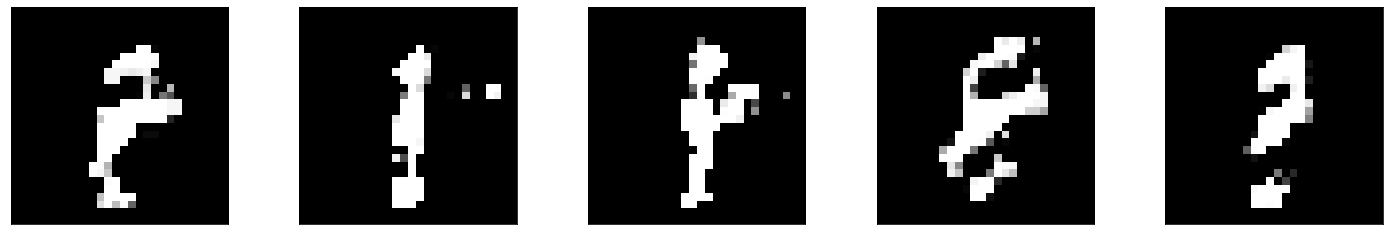

In [51]:
#for i in range(5):
nb_images = 5
bottleneck = 20
rand_features = torch.cuda.FloatTensor(nb_images, bottleneck).normal_()
output = model.decoder(rand_features)
#Visualisation
output = output.cpu().detach().numpy()
images_width = 28
fig, axes = plt.subplots(nrows=1,ncols=5,sharex=True,sharey=True,figsize=(25,4))
decoded_images = output[:nb_images]  
for ax, img in zip(axes, decoded_images):
    ax.imshow(np.squeeze(img), cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

#Exercice B#

Here is two funtions the first one returns some normal noize and the second one is here to init the weight of the model

In [0]:
def norm_noise(size):
    return torch.cuda.FloatTensor(size,64).normal_()
  
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('layers') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

def display_batch_images(img, imtype=np.uint8, unnormalize=True, nrows=None, mean=0.5, std=0.5):
    # select a sample or create grid if img is a batch
    if len(img.shape) == 4:
        nrows = nrows if nrows is not None else int(math.sqrt(img.size(0)))
        img = utils.make_grid(img, nrow=nrows)

    # unnormalize
    img = img.cpu().float()
    img = (img*std+mean)*255

    # to numpy
    image_numpy = img.numpy()
    image_numpy = np.transpose(image_numpy, (1, 2, 0))
    display(Image.fromarray(image_numpy.astype(imtype))) 

Class Generator base on the decoder

In [0]:
class Generator(torch.nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = Decoder(64)

    def forward(self, x):
        # Noise to image
        return self.layers(x)

Definition class Discriminator

In [0]:
class Discriminator(torch.nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = Encoder(10)
        self.fc = nn.Sequential(
            nn.Linear(10,1),
            nn.Sigmoid()
        )
    def forward(self,x):
      x= self.layers(x)
      x= self.fc(x)
      return x   

**Model** For all the run

In [0]:
class Model:
    # --------------------------
    # -- PREPARE MODEL
    # --------------------------
    
    def __init__(self, batch_size):
        self._create_networks()
        self._create_optimizer()
        self._init_criterion(batch_size)
        
    def _create_networks(self):
        # create networks
        self._generator = Generator()
        self._discriminator = Discriminator()
        
        # init weights
        self._generator.apply(init_weights)
        self._discriminator.apply(init_weights)
        
        # move to cuda
        self._generator.cuda()
        self._discriminator.cuda()
        
    def _create_optimizer(self):
        # generator optimizer
        self._opt_g = torch.optim.Adam(self._generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        # discriminator optimizer
        self._opt_d = torch.optim.Adam(self._discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
    def _init_criterion(self, batch_size):
        self._criterion = nn.BCELoss()
        self._label_real = Variable(torch.ones(batch_size, 1)).cuda()
        self._label_fake = Variable(torch.zeros(batch_size, 1)).cuda()
        
    # --------------------------
    # -- Generate Fake Samples
    # --------------------------
    
    def generate_samples(self, batch_size, z=None):
        # sample random noise
        if z is None:
            z = norm_noise(batch_size)
            
        # TODO: generate fake samples out of the random noise z
        fake_samples = self._generator(z)
        return fake_samples
    
    # --------------------------
    # -- Optimize Model
    # --------------------------
        
    def step_optimization(self, real_samples):
        # generate fake samples
        fake_samples = self.generate_samples(real_samples.size(0))
        
        # optimize generator
        loss_g = self._step_opt_g(fake_samples)
        
        # optimize discriminator
        loss_d = self._step_opt_d(real_samples, fake_samples.detach())
        
        return loss_g, loss_d
      
    def _step_opt_g(self, fake_samples):
        # Reset gradients
        self._opt_g.zero_grad()
        
        # TODO: Calculate generator loss
        estim_fake =  self._discriminator(fake_samples)
        loss = self._criterion(estim_fake,self._label_real)
        loss.backward()
        
        # Update weights
        self._opt_g.step()
        
        return loss.item()
        
    def _step_opt_d(self, real_samples, fake_samples):
        # Reset gradients
        self._opt_d.zero_grad()

        # TODO: Calculate discriminator loss for real samples
        estim_real =self._discriminator(real_samples)
        loss_real = self._criterion(estim_real,self._label_real)

        # TODO: Calculate discriminator loss for fake samples
        estim_fake =  self._discriminator(fake_samples)
        loss_fake = self._criterion(estim_fake, self._label_fake)
        
        # Total discriminator loss
        loss = (loss_real + loss_fake) / 2
        loss.backward()

        # Update weights
        self._opt_d.step()

        return loss_real.item(), loss_fake.item()
        
  

Now we train the model

In [0]:
num_epochs = 300
num_val_samples = 25
z_val = norm_noise(num_val_samples)
model = Model(hparams['batch_size'])

epoch: 0/300, batch: 0/891, G_loss: 0.5551452040672302, D_loss: (0.5461821556091309, 0.8519254326820374)


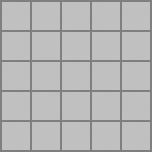

epoch: 0/300, batch: 10/891, G_loss: 0.514065146446228, D_loss: (0.1620040088891983, 0.9114574790000916)
epoch: 0/300, batch: 20/891, G_loss: 0.6010158061981201, D_loss: (0.011050617322325706, 0.7948015928268433)
epoch: 0/300, batch: 30/891, G_loss: 1.553149700164795, D_loss: (0.0398891344666481, 0.2539917826652527)
epoch: 0/300, batch: 40/891, G_loss: 3.6503398418426514, D_loss: (0.0013388799270614982, 0.03375507518649101)
epoch: 0/300, batch: 50/891, G_loss: 4.987757682800293, D_loss: (0.0003132823039777577, 0.00767182745039463)
epoch: 0/300, batch: 60/891, G_loss: 5.241269111633301, D_loss: (4.45748946731328e-06, 0.006761242635548115)
epoch: 0/300, batch: 70/891, G_loss: 6.2185468673706055, D_loss: (0.006024587899446487, 0.0024360325187444687)
epoch: 0/300, batch: 80/891, G_loss: 5.968655586242676, D_loss: (1.1455456387921004e-06, 0.003661414608359337)
epoch: 0/300, batch: 90/891, G_loss: 6.763905048370361, D_loss: (1.7393784219166264e-05, 0.0016671960474923253)
epoch: 0/300, batch:

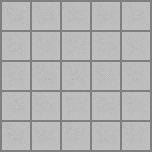

epoch: 0/300, batch: 110/891, G_loss: 4.747158050537109, D_loss: (3.725290742551124e-09, 0.013768693432211876)
epoch: 0/300, batch: 120/891, G_loss: 7.198852062225342, D_loss: (1.9744078372241347e-07, 0.0009456683765165508)
epoch: 0/300, batch: 130/891, G_loss: 7.512251377105713, D_loss: (1.4528967540172744e-06, 0.0007837633020244539)
epoch: 0/300, batch: 140/891, G_loss: 7.559042930603027, D_loss: (9.313226634333205e-09, 0.000609622395131737)
epoch: 0/300, batch: 150/891, G_loss: 7.80894136428833, D_loss: (5.029146876722734e-08, 0.0006170484120957553)
epoch: 0/300, batch: 160/891, G_loss: 7.4269819259643555, D_loss: (3.725290742551124e-09, 0.0009549625683575869)
epoch: 0/300, batch: 170/891, G_loss: 7.727121353149414, D_loss: (0.0, 0.0006157002062536776)
epoch: 0/300, batch: 180/891, G_loss: 8.283952713012695, D_loss: (1.3098005183564965e-05, 0.0004451081913430244)
epoch: 0/300, batch: 190/891, G_loss: 8.326326370239258, D_loss: (2.756733863407135e-07, 0.0004134856862947345)
epoch: 0/

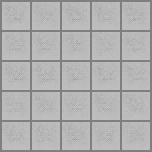

epoch: 0/300, batch: 210/891, G_loss: 8.627311706542969, D_loss: (2.3655643133224658e-07, 0.0003074099658988416)
epoch: 0/300, batch: 220/891, G_loss: 8.894515991210938, D_loss: (5.665820481226547e-06, 0.00020310183754190803)
epoch: 0/300, batch: 230/891, G_loss: 8.998065948486328, D_loss: (5.438994890027971e-07, 0.00018134634592570364)
epoch: 0/300, batch: 240/891, G_loss: 8.93525505065918, D_loss: (1.3984882571094204e-05, 0.0001841940829763189)
epoch: 0/300, batch: 250/891, G_loss: 8.894636154174805, D_loss: (1.886958557406615e-06, 0.00021266785915941)
epoch: 0/300, batch: 260/891, G_loss: 7.716901779174805, D_loss: (0.0, 0.0008414027979597449)
epoch: 0/300, batch: 270/891, G_loss: 8.182051658630371, D_loss: (0.0, 0.0003243352985009551)
epoch: 0/300, batch: 280/891, G_loss: 8.610595703125, D_loss: (5.0291490083509416e-08, 0.00024878024123609066)
epoch: 0/300, batch: 290/891, G_loss: 8.708273887634277, D_loss: (5.495769528351957e-06, 0.00020258314907550812)
epoch: 0/300, batch: 300/89

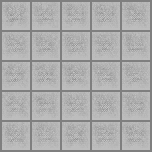

epoch: 0/300, batch: 310/891, G_loss: 8.927242279052734, D_loss: (0.0, 0.00017754084547050297)
epoch: 0/300, batch: 320/891, G_loss: 9.0160551071167, D_loss: (0.0, 0.00016079426859505475)
epoch: 0/300, batch: 330/891, G_loss: 8.993706703186035, D_loss: (0.0, 0.00014916181680746377)
epoch: 0/300, batch: 340/891, G_loss: 9.203511238098145, D_loss: (1.862645371275562e-09, 0.00017766034579835832)
epoch: 0/300, batch: 350/891, G_loss: 9.225059509277344, D_loss: (0.0, 0.00015788750897627324)
epoch: 0/300, batch: 360/891, G_loss: 9.100723266601562, D_loss: (1.862645371275562e-09, 0.00014478986850008368)
epoch: 0/300, batch: 370/891, G_loss: 8.619011878967285, D_loss: (0.0, 0.00022252897906582803)
epoch: 0/300, batch: 380/891, G_loss: 8.698033332824707, D_loss: (0.0, 0.0002347372646909207)
epoch: 0/300, batch: 390/891, G_loss: 8.716835021972656, D_loss: (0.0, 0.00023464157129637897)
epoch: 0/300, batch: 400/891, G_loss: 8.63740062713623, D_loss: (0.0, 0.00020476346253417432)


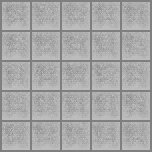

epoch: 0/300, batch: 410/891, G_loss: 8.917845726013184, D_loss: (1.117587533627784e-08, 0.00019832786347251385)
epoch: 0/300, batch: 420/891, G_loss: 9.012276649475098, D_loss: (1.862645371275562e-09, 0.00016528062405996025)
epoch: 0/300, batch: 430/891, G_loss: 9.002199172973633, D_loss: (0.0, 0.000158217444550246)
epoch: 0/300, batch: 440/891, G_loss: 8.920607566833496, D_loss: (0.0, 0.00017383821250405163)
epoch: 0/300, batch: 450/891, G_loss: 9.151509284973145, D_loss: (0.0, 0.00014460131933446974)
epoch: 0/300, batch: 460/891, G_loss: 9.007183074951172, D_loss: (0.0, 0.00016800733283162117)
epoch: 0/300, batch: 470/891, G_loss: 8.992772102355957, D_loss: (0.0, 0.00016521246288903058)
epoch: 0/300, batch: 480/891, G_loss: 9.343358993530273, D_loss: (0.0, 0.00012567080557346344)
epoch: 0/300, batch: 490/891, G_loss: 9.050752639770508, D_loss: (1.8626560915890877e-07, 0.00013822628534398973)
epoch: 0/300, batch: 500/891, G_loss: 9.092573165893555, D_loss: (0.0, 0.0001570178137626499

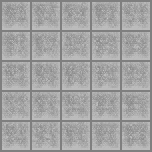

epoch: 0/300, batch: 510/891, G_loss: 8.949783325195312, D_loss: (0.0, 0.00016173605399671942)
epoch: 0/300, batch: 520/891, G_loss: 6.871316909790039, D_loss: (0.0, 0.0015821390552446246)
epoch: 0/300, batch: 530/891, G_loss: 8.175891876220703, D_loss: (0.0, 0.0003356346278451383)
epoch: 0/300, batch: 540/891, G_loss: 8.512951850891113, D_loss: (0.0, 0.0003112360427621752)
epoch: 0/300, batch: 550/891, G_loss: 8.736295700073242, D_loss: (0.0, 0.0003297491930425167)
epoch: 0/300, batch: 560/891, G_loss: 8.977447509765625, D_loss: (0.0, 0.00016486321692354977)
epoch: 0/300, batch: 570/891, G_loss: 8.880245208740234, D_loss: (0.0, 0.0002004505950026214)
epoch: 0/300, batch: 580/891, G_loss: 9.131021499633789, D_loss: (3.725290742551124e-09, 0.0001638386311242357)
epoch: 0/300, batch: 590/891, G_loss: 8.993694305419922, D_loss: (0.0, 0.00016276199312414974)
epoch: 0/300, batch: 600/891, G_loss: 9.156698226928711, D_loss: (0.0, 0.00015821345732547343)


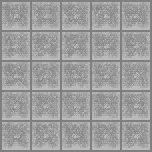

epoch: 0/300, batch: 610/891, G_loss: 9.050567626953125, D_loss: (0.0, 0.0001336941495537758)
epoch: 0/300, batch: 620/891, G_loss: 9.292619705200195, D_loss: (0.0, 0.00011765702947741374)
epoch: 0/300, batch: 630/891, G_loss: 9.37094497680664, D_loss: (9.313228410690044e-09, 0.00013636768562719226)
epoch: 0/300, batch: 640/891, G_loss: 1.9726648330688477, D_loss: (0.0, 0.15870539844036102)
epoch: 0/300, batch: 650/891, G_loss: 4.397552490234375, D_loss: (0.0, 0.013403749093413353)
epoch: 0/300, batch: 660/891, G_loss: 4.831330299377441, D_loss: (0.0, 0.007899587042629719)
epoch: 0/300, batch: 670/891, G_loss: 5.2656755447387695, D_loss: (0.0, 0.00622115982696414)
epoch: 0/300, batch: 680/891, G_loss: 5.576635837554932, D_loss: (0.0, 0.004269066266715527)
epoch: 0/300, batch: 690/891, G_loss: 5.664059638977051, D_loss: (0.0, 0.003470140043646097)
epoch: 0/300, batch: 700/891, G_loss: 5.972158432006836, D_loss: (0.0, 0.00301149720326066)


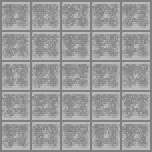

epoch: 0/300, batch: 710/891, G_loss: 6.200250148773193, D_loss: (0.0, 0.0024945279583334923)
epoch: 0/300, batch: 720/891, G_loss: 6.251193046569824, D_loss: (0.0, 0.002200587885454297)
epoch: 0/300, batch: 730/891, G_loss: 6.22111701965332, D_loss: (0.0, 0.0018388500902801752)
epoch: 0/300, batch: 740/891, G_loss: 6.559752941131592, D_loss: (0.0, 0.0018892420921474695)
epoch: 0/300, batch: 750/891, G_loss: 6.526354789733887, D_loss: (0.0, 0.0017668940126895905)
epoch: 0/300, batch: 760/891, G_loss: 6.577330589294434, D_loss: (0.0, 0.0016366207273676991)
epoch: 0/300, batch: 770/891, G_loss: 6.5965375900268555, D_loss: (0.0, 0.0013870785478502512)
epoch: 0/300, batch: 780/891, G_loss: 6.6750264167785645, D_loss: (0.0, 0.0014756937744095922)
epoch: 0/300, batch: 790/891, G_loss: 6.608922004699707, D_loss: (0.0, 0.001540939323604107)
epoch: 0/300, batch: 800/891, G_loss: 6.870301246643066, D_loss: (0.0, 0.0016415456775575876)


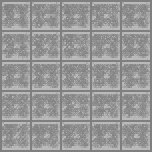

epoch: 0/300, batch: 810/891, G_loss: 6.704074859619141, D_loss: (0.0, 0.001637265202589333)
epoch: 0/300, batch: 820/891, G_loss: 6.864607334136963, D_loss: (0.0, 0.0012759092496708035)
epoch: 0/300, batch: 830/891, G_loss: 6.688995361328125, D_loss: (0.0, 0.0013669442851096392)
epoch: 0/300, batch: 840/891, G_loss: 6.808830738067627, D_loss: (0.0, 0.0014688322553411126)
epoch: 0/300, batch: 850/891, G_loss: 6.884207248687744, D_loss: (0.0, 0.001127387396991253)
epoch: 0/300, batch: 860/891, G_loss: 6.766166687011719, D_loss: (0.0, 0.0011172699742019176)
epoch: 0/300, batch: 870/891, G_loss: 6.933572769165039, D_loss: (0.0, 0.001265050144866109)
epoch: 0/300, batch: 880/891, G_loss: 6.835351943969727, D_loss: (0.0, 0.0010202936828136444)
epoch: 0/300, batch: 890/891, G_loss: 6.96372127532959, D_loss: (0.0, 0.0009199822670780122)
epoch: 1/300, batch: 0/891, G_loss: 6.89380407333374, D_loss: (0.0, 0.0011218470754101872)


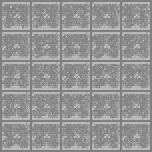

epoch: 1/300, batch: 10/891, G_loss: 7.006383895874023, D_loss: (0.0, 0.0011070235632359982)
epoch: 1/300, batch: 20/891, G_loss: 7.043164253234863, D_loss: (0.0, 0.001067892531864345)
epoch: 1/300, batch: 30/891, G_loss: 7.029146194458008, D_loss: (0.0, 0.0010077416663989425)
epoch: 1/300, batch: 40/891, G_loss: 7.050880432128906, D_loss: (0.0, 0.0009662987431511283)
epoch: 1/300, batch: 50/891, G_loss: 6.824209213256836, D_loss: (0.0, 0.0011073164641857147)
epoch: 1/300, batch: 60/891, G_loss: 7.088739395141602, D_loss: (0.0, 0.0010221315314993262)
epoch: 1/300, batch: 70/891, G_loss: 7.090814590454102, D_loss: (0.0, 0.0011340754572302103)
epoch: 1/300, batch: 80/891, G_loss: 7.227634429931641, D_loss: (0.0, 0.001082767266780138)
epoch: 1/300, batch: 90/891, G_loss: 7.104484558105469, D_loss: (0.0, 0.0010324487229809165)
epoch: 1/300, batch: 100/891, G_loss: 7.085102081298828, D_loss: (0.0, 0.0009990038815885782)


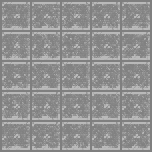

epoch: 1/300, batch: 110/891, G_loss: 7.052977085113525, D_loss: (0.0, 0.0009751252364367247)
epoch: 1/300, batch: 120/891, G_loss: 7.143370628356934, D_loss: (0.0, 0.0011282850755378604)
epoch: 1/300, batch: 130/891, G_loss: 7.139017105102539, D_loss: (0.0, 0.0008898453088477254)
epoch: 1/300, batch: 140/891, G_loss: 7.16192626953125, D_loss: (0.0, 0.0009629480773583055)
epoch: 1/300, batch: 150/891, G_loss: 7.172482490539551, D_loss: (0.0, 0.0010304362513124943)
epoch: 1/300, batch: 160/891, G_loss: 7.0474958419799805, D_loss: (0.0, 0.0012078359723091125)
epoch: 1/300, batch: 170/891, G_loss: 7.354400634765625, D_loss: (0.0, 0.001005143509246409)
epoch: 1/300, batch: 180/891, G_loss: 7.190666198730469, D_loss: (0.0, 0.0007956392364576459)
epoch: 1/300, batch: 190/891, G_loss: 7.389727592468262, D_loss: (0.0, 0.0007996830390766263)
epoch: 1/300, batch: 200/891, G_loss: 7.239302635192871, D_loss: (0.0, 0.0008823720272630453)


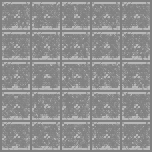

epoch: 1/300, batch: 210/891, G_loss: 7.379748344421387, D_loss: (0.0, 0.0007373344851657748)
epoch: 1/300, batch: 220/891, G_loss: 7.430768966674805, D_loss: (0.0, 0.0007438158500008285)
epoch: 1/300, batch: 230/891, G_loss: 7.321976661682129, D_loss: (0.0, 0.0008691528346389532)
epoch: 1/300, batch: 240/891, G_loss: 7.4010233879089355, D_loss: (0.0, 0.0007901884382590652)
epoch: 1/300, batch: 250/891, G_loss: 7.27767276763916, D_loss: (0.0, 0.0007978047942742705)
epoch: 1/300, batch: 260/891, G_loss: 7.365232944488525, D_loss: (0.0, 0.0007733703823760152)
epoch: 1/300, batch: 270/891, G_loss: 7.418540000915527, D_loss: (0.0, 0.0006130782421678305)
epoch: 1/300, batch: 280/891, G_loss: 7.549251556396484, D_loss: (0.0, 0.000744675868190825)
epoch: 1/300, batch: 290/891, G_loss: 7.510952472686768, D_loss: (0.0, 0.0006557365413755178)
epoch: 1/300, batch: 300/891, G_loss: 7.537668228149414, D_loss: (0.0, 0.0006459938012994826)


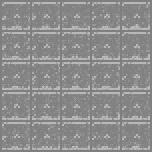

epoch: 1/300, batch: 310/891, G_loss: 7.578668594360352, D_loss: (0.0, 0.0005703982315026224)
epoch: 1/300, batch: 320/891, G_loss: 7.719832897186279, D_loss: (0.0, 0.0005590914515778422)
epoch: 1/300, batch: 330/891, G_loss: 7.642542362213135, D_loss: (0.0, 0.0005384663818404078)
epoch: 1/300, batch: 340/891, G_loss: 7.721181392669678, D_loss: (0.0, 0.0006050780066289008)
epoch: 1/300, batch: 350/891, G_loss: 7.7316083908081055, D_loss: (0.0, 0.0006525017088279128)
epoch: 1/300, batch: 360/891, G_loss: 7.711835861206055, D_loss: (0.0, 0.0005291097331792116)
epoch: 1/300, batch: 370/891, G_loss: 7.642518997192383, D_loss: (0.0, 0.0005629333318211138)
epoch: 1/300, batch: 380/891, G_loss: 7.822981834411621, D_loss: (0.0, 0.0004644508589990437)
epoch: 1/300, batch: 390/891, G_loss: 7.734499931335449, D_loss: (0.0, 0.0005133326048962772)
epoch: 1/300, batch: 400/891, G_loss: 7.788113594055176, D_loss: (0.0, 0.00039711903082206845)


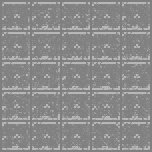

epoch: 1/300, batch: 410/891, G_loss: 7.9488372802734375, D_loss: (0.0, 0.00046314409701153636)
epoch: 1/300, batch: 420/891, G_loss: 7.823068618774414, D_loss: (0.0, 0.0004356624558568001)
epoch: 1/300, batch: 430/891, G_loss: 7.895203113555908, D_loss: (0.0, 0.00040933408308774233)
epoch: 1/300, batch: 440/891, G_loss: 8.13504409790039, D_loss: (0.0, 0.0004296108381822705)
epoch: 1/300, batch: 450/891, G_loss: 7.999352931976318, D_loss: (0.0, 0.00039337296038866043)
epoch: 1/300, batch: 460/891, G_loss: 7.954442024230957, D_loss: (0.0, 0.0004189484752714634)
epoch: 1/300, batch: 470/891, G_loss: 8.109529495239258, D_loss: (0.0, 0.00044943735701963305)
epoch: 1/300, batch: 480/891, G_loss: 8.067811012268066, D_loss: (0.0, 0.00043012911919504404)
epoch: 1/300, batch: 490/891, G_loss: 8.279308319091797, D_loss: (0.0, 0.00036195944994688034)
epoch: 1/300, batch: 500/891, G_loss: 8.23836898803711, D_loss: (0.0, 0.000362675404176116)


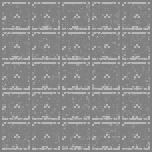

epoch: 1/300, batch: 510/891, G_loss: 8.16911506652832, D_loss: (0.0, 0.0003390154743101448)
epoch: 1/300, batch: 520/891, G_loss: 8.084528923034668, D_loss: (0.0, 0.00039199896855279803)
epoch: 1/300, batch: 530/891, G_loss: 8.264713287353516, D_loss: (0.0, 0.0003105483192484826)
epoch: 1/300, batch: 540/891, G_loss: 8.363112449645996, D_loss: (0.0, 0.00032362370984628797)
epoch: 1/300, batch: 550/891, G_loss: 8.305997848510742, D_loss: (0.0, 0.00032617890974506736)
epoch: 1/300, batch: 560/891, G_loss: 8.29345703125, D_loss: (0.0, 0.00032517730141989887)
epoch: 1/300, batch: 570/891, G_loss: 8.17985725402832, D_loss: (0.0, 0.0002859634696505964)
epoch: 1/300, batch: 580/891, G_loss: 8.397943496704102, D_loss: (0.0, 0.0003137683670502156)
epoch: 1/300, batch: 590/891, G_loss: 8.261897087097168, D_loss: (0.0, 0.00034195423359051347)
epoch: 1/300, batch: 600/891, G_loss: 8.334446907043457, D_loss: (0.0, 0.00033684499794617295)


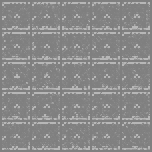

epoch: 1/300, batch: 610/891, G_loss: 8.314107894897461, D_loss: (0.0, 0.000270941382041201)
epoch: 1/300, batch: 620/891, G_loss: 8.4989652633667, D_loss: (0.0, 0.0002677151933312416)
epoch: 1/300, batch: 630/891, G_loss: 8.582709312438965, D_loss: (0.0, 0.0002850654418580234)
epoch: 1/300, batch: 640/891, G_loss: 8.495903015136719, D_loss: (0.0, 0.0002528175828047097)
epoch: 1/300, batch: 650/891, G_loss: 8.377288818359375, D_loss: (0.0, 0.00025235998327843845)
epoch: 1/300, batch: 660/891, G_loss: 8.454259872436523, D_loss: (0.0, 0.00026649466599337757)
epoch: 1/300, batch: 670/891, G_loss: 8.595077514648438, D_loss: (0.0, 0.00024601526092737913)
epoch: 1/300, batch: 680/891, G_loss: 8.70081615447998, D_loss: (0.0, 0.00020423668320290744)
epoch: 1/300, batch: 690/891, G_loss: 8.62772274017334, D_loss: (0.0, 0.0002264045615447685)
epoch: 1/300, batch: 700/891, G_loss: 8.642024040222168, D_loss: (0.0, 0.00020682267495431006)


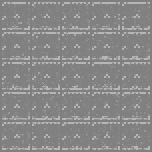

epoch: 1/300, batch: 710/891, G_loss: 8.54484748840332, D_loss: (0.0, 0.00022263180289883167)
epoch: 1/300, batch: 720/891, G_loss: 8.68283462524414, D_loss: (0.0, 0.0002823777904268354)
epoch: 1/300, batch: 730/891, G_loss: 8.855624198913574, D_loss: (0.0, 0.0002577554841991514)
epoch: 1/300, batch: 740/891, G_loss: 8.745100021362305, D_loss: (0.0, 0.0002328927512280643)
epoch: 1/300, batch: 750/891, G_loss: 8.839897155761719, D_loss: (0.0, 0.0002454213972669095)
epoch: 1/300, batch: 760/891, G_loss: 8.716086387634277, D_loss: (0.0, 0.00018644166993908584)
epoch: 1/300, batch: 770/891, G_loss: 8.870192527770996, D_loss: (0.0, 0.00020185299217700958)
epoch: 1/300, batch: 780/891, G_loss: 8.796886444091797, D_loss: (0.0, 0.00016653191414661705)
epoch: 1/300, batch: 790/891, G_loss: 8.824771881103516, D_loss: (0.0, 0.00015905770123936236)
epoch: 1/300, batch: 800/891, G_loss: 8.790271759033203, D_loss: (0.0, 0.00019087683176621795)


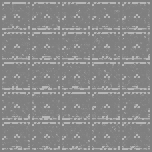

epoch: 1/300, batch: 810/891, G_loss: 9.107982635498047, D_loss: (0.0, 0.00015454685490112752)
epoch: 1/300, batch: 820/891, G_loss: 8.930707931518555, D_loss: (0.0, 0.00015545528731308877)
epoch: 1/300, batch: 830/891, G_loss: 8.778090476989746, D_loss: (0.0, 0.00018083873146679252)
epoch: 1/300, batch: 840/891, G_loss: 9.130517959594727, D_loss: (0.0, 0.00015954344416968524)
epoch: 1/300, batch: 850/891, G_loss: 8.963749885559082, D_loss: (0.0, 0.00014710798859596252)
epoch: 1/300, batch: 860/891, G_loss: 9.053972244262695, D_loss: (0.0, 0.0001541326055303216)
epoch: 1/300, batch: 870/891, G_loss: 9.059386253356934, D_loss: (0.0, 0.00016615467029623687)
epoch: 1/300, batch: 880/891, G_loss: 9.033308029174805, D_loss: (0.0, 0.0001576766953803599)
epoch: 1/300, batch: 890/891, G_loss: 9.014276504516602, D_loss: (0.0, 0.00015307898866012692)
epoch: 2/300, batch: 0/891, G_loss: 9.000020980834961, D_loss: (0.0, 0.00016047360259108245)


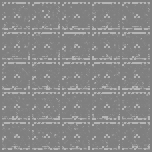

epoch: 2/300, batch: 10/891, G_loss: 9.109941482543945, D_loss: (0.0, 0.000167769321706146)
epoch: 2/300, batch: 20/891, G_loss: 9.12084674835205, D_loss: (0.0, 0.00015315668133553118)
epoch: 2/300, batch: 30/891, G_loss: 8.888875961303711, D_loss: (0.0, 0.00015816959785297513)
epoch: 2/300, batch: 40/891, G_loss: 8.987424850463867, D_loss: (0.0, 0.000149179992149584)
epoch: 2/300, batch: 50/891, G_loss: 9.213888168334961, D_loss: (0.0, 0.00015914386312942952)
epoch: 2/300, batch: 60/891, G_loss: 9.205952644348145, D_loss: (0.0, 0.0001451862190151587)
epoch: 2/300, batch: 70/891, G_loss: 9.248722076416016, D_loss: (0.0, 0.00012265495024621487)
epoch: 2/300, batch: 80/891, G_loss: 9.229031562805176, D_loss: (0.0, 0.00011365777027094737)
epoch: 2/300, batch: 90/891, G_loss: 9.067123413085938, D_loss: (0.0, 0.00012979059829376638)
epoch: 2/300, batch: 100/891, G_loss: 9.218737602233887, D_loss: (0.0, 0.00012977462029084563)


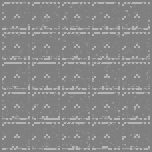

epoch: 2/300, batch: 110/891, G_loss: 9.16476821899414, D_loss: (0.0, 0.0001266413164557889)
epoch: 2/300, batch: 120/891, G_loss: 9.232343673706055, D_loss: (0.0, 0.00013227705494500697)
epoch: 2/300, batch: 130/891, G_loss: 9.469051361083984, D_loss: (0.0, 0.00013128097634762526)
epoch: 2/300, batch: 140/891, G_loss: 9.360837936401367, D_loss: (0.0, 0.00013421331823337823)
epoch: 2/300, batch: 150/891, G_loss: 9.492191314697266, D_loss: (0.0, 0.0001051765721058473)
epoch: 2/300, batch: 160/891, G_loss: 9.397241592407227, D_loss: (0.0, 0.00010882668721023947)
epoch: 2/300, batch: 170/891, G_loss: 9.343843460083008, D_loss: (0.0, 0.00010373771510785446)
epoch: 2/300, batch: 180/891, G_loss: 9.450679779052734, D_loss: (0.0, 0.00011382077354937792)
epoch: 2/300, batch: 190/891, G_loss: 9.552824020385742, D_loss: (0.0, 0.00012254813918843865)
epoch: 2/300, batch: 200/891, G_loss: 9.331001281738281, D_loss: (0.0, 0.00010787964856717736)


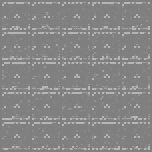

epoch: 2/300, batch: 210/891, G_loss: 9.532776832580566, D_loss: (0.0, 0.00011237805301789194)
epoch: 2/300, batch: 220/891, G_loss: 9.320777893066406, D_loss: (0.0, 0.00011784283560700715)
epoch: 2/300, batch: 230/891, G_loss: 9.393865585327148, D_loss: (0.0, 0.00012705422705039382)
epoch: 2/300, batch: 240/891, G_loss: 9.56037712097168, D_loss: (0.0, 9.926370694302022e-05)
epoch: 2/300, batch: 250/891, G_loss: 9.40473747253418, D_loss: (0.0, 0.0001050293940352276)
epoch: 2/300, batch: 260/891, G_loss: 9.390512466430664, D_loss: (0.0, 0.00013184668205212802)
epoch: 2/300, batch: 270/891, G_loss: 9.362804412841797, D_loss: (0.0, 0.00012023856834275648)
epoch: 2/300, batch: 280/891, G_loss: 9.482406616210938, D_loss: (0.0, 0.00010827556252479553)
epoch: 2/300, batch: 290/891, G_loss: 9.455333709716797, D_loss: (0.0, 7.83629366196692e-05)
epoch: 2/300, batch: 300/891, G_loss: 9.372806549072266, D_loss: (0.0, 9.090422827284783e-05)


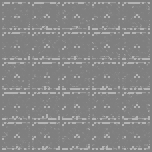

epoch: 2/300, batch: 310/891, G_loss: 9.560262680053711, D_loss: (0.0, 9.502134344074875e-05)
epoch: 2/300, batch: 320/891, G_loss: 9.252527236938477, D_loss: (0.0, 0.00010407614900032058)
epoch: 2/300, batch: 330/891, G_loss: 9.591285705566406, D_loss: (0.0, 9.485076589044183e-05)
epoch: 2/300, batch: 340/891, G_loss: 9.464127540588379, D_loss: (0.0, 8.674644777784124e-05)
epoch: 2/300, batch: 350/891, G_loss: 9.561245918273926, D_loss: (0.0, 9.244498505722731e-05)
epoch: 2/300, batch: 360/891, G_loss: 9.608201026916504, D_loss: (0.0, 7.924620877020061e-05)
epoch: 2/300, batch: 370/891, G_loss: 9.592002868652344, D_loss: (0.0, 9.43310878938064e-05)
epoch: 2/300, batch: 380/891, G_loss: 9.53136920928955, D_loss: (0.0, 7.514525350416079e-05)
epoch: 2/300, batch: 390/891, G_loss: 9.606165885925293, D_loss: (0.0, 8.308405085699633e-05)
epoch: 2/300, batch: 400/891, G_loss: 9.59556770324707, D_loss: (0.0, 8.461199468001723e-05)


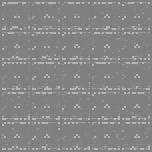

epoch: 2/300, batch: 410/891, G_loss: 9.614657402038574, D_loss: (0.0, 0.00010810357343871146)
epoch: 2/300, batch: 420/891, G_loss: 9.469396591186523, D_loss: (0.0, 7.981220551300794e-05)
epoch: 2/300, batch: 430/891, G_loss: 9.657522201538086, D_loss: (0.0, 7.743877358734608e-05)
epoch: 2/300, batch: 440/891, G_loss: 9.66724967956543, D_loss: (0.0, 8.420823724009097e-05)
epoch: 2/300, batch: 450/891, G_loss: 9.802490234375, D_loss: (0.0, 7.355236448347569e-05)
epoch: 2/300, batch: 460/891, G_loss: 9.772289276123047, D_loss: (0.0, 8.434748451691121e-05)
epoch: 2/300, batch: 470/891, G_loss: 9.676618576049805, D_loss: (0.0, 7.737109262961894e-05)
epoch: 2/300, batch: 480/891, G_loss: 9.648077011108398, D_loss: (0.0, 8.766910468693823e-05)
epoch: 2/300, batch: 490/891, G_loss: 9.654838562011719, D_loss: (0.0, 7.564995030406862e-05)
epoch: 2/300, batch: 500/891, G_loss: 9.768594741821289, D_loss: (0.0, 8.969942427938804e-05)


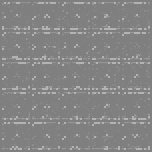

epoch: 2/300, batch: 510/891, G_loss: 9.91571044921875, D_loss: (0.0, 7.928741979412735e-05)
epoch: 2/300, batch: 520/891, G_loss: 10.051901817321777, D_loss: (0.0, 8.366639667656273e-05)
epoch: 2/300, batch: 530/891, G_loss: 9.861024856567383, D_loss: (0.0, 6.56635602354072e-05)
epoch: 2/300, batch: 540/891, G_loss: 9.939104080200195, D_loss: (0.0, 7.537181954830885e-05)
epoch: 2/300, batch: 550/891, G_loss: 9.772468566894531, D_loss: (0.0, 6.812960782554e-05)
epoch: 2/300, batch: 560/891, G_loss: 9.774133682250977, D_loss: (0.0, 6.646099791396409e-05)
epoch: 2/300, batch: 570/891, G_loss: 9.788445472717285, D_loss: (0.0, 6.636863690800965e-05)
epoch: 2/300, batch: 580/891, G_loss: 10.0709228515625, D_loss: (0.0, 6.199959170771763e-05)
epoch: 2/300, batch: 590/891, G_loss: 10.02165699005127, D_loss: (0.0, 7.898353214841336e-05)
epoch: 2/300, batch: 600/891, G_loss: 9.906716346740723, D_loss: (0.0, 5.785630128229968e-05)


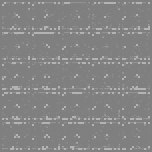

epoch: 2/300, batch: 610/891, G_loss: 9.78036117553711, D_loss: (0.0, 7.364930934272707e-05)
epoch: 2/300, batch: 620/891, G_loss: 9.938682556152344, D_loss: (0.0, 8.348583651240915e-05)
epoch: 2/300, batch: 630/891, G_loss: 10.001272201538086, D_loss: (0.0, 6.182741344673559e-05)
epoch: 2/300, batch: 640/891, G_loss: 10.055212020874023, D_loss: (0.0, 6.803504220442846e-05)
epoch: 2/300, batch: 650/891, G_loss: 10.03785514831543, D_loss: (0.0, 5.282420170260593e-05)
epoch: 2/300, batch: 660/891, G_loss: 10.008587837219238, D_loss: (0.0, 5.172228702576831e-05)
epoch: 2/300, batch: 670/891, G_loss: 10.127442359924316, D_loss: (0.0, 6.390047201421112e-05)
epoch: 2/300, batch: 680/891, G_loss: 10.142932891845703, D_loss: (0.0, 8.153878297889605e-05)
epoch: 2/300, batch: 690/891, G_loss: 10.115434646606445, D_loss: (0.0, 5.012402107240632e-05)
epoch: 2/300, batch: 700/891, G_loss: 10.12175178527832, D_loss: (0.0, 5.4749623814132065e-05)


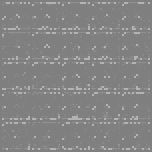

epoch: 2/300, batch: 710/891, G_loss: 10.099346160888672, D_loss: (0.0, 5.1592753152363e-05)
epoch: 2/300, batch: 720/891, G_loss: 10.199859619140625, D_loss: (0.0, 5.5339023674605414e-05)
epoch: 2/300, batch: 730/891, G_loss: 10.111157417297363, D_loss: (0.0, 7.422722410410643e-05)
epoch: 2/300, batch: 740/891, G_loss: 10.139734268188477, D_loss: (0.0, 4.552931568468921e-05)
epoch: 2/300, batch: 750/891, G_loss: 10.289488792419434, D_loss: (0.0, 6.403234147001058e-05)
epoch: 2/300, batch: 760/891, G_loss: 10.193656921386719, D_loss: (0.0, 5.071111081633717e-05)
epoch: 2/300, batch: 770/891, G_loss: 10.509063720703125, D_loss: (0.0, 4.929167698719539e-05)
epoch: 2/300, batch: 780/891, G_loss: 10.253969192504883, D_loss: (0.0, 7.097751222318038e-05)
epoch: 2/300, batch: 790/891, G_loss: 10.169120788574219, D_loss: (0.0, 4.640492988983169e-05)
epoch: 2/300, batch: 800/891, G_loss: 10.258878707885742, D_loss: (0.0, 5.3594954806612805e-05)


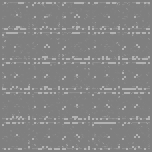

epoch: 2/300, batch: 810/891, G_loss: 10.186819076538086, D_loss: (0.0, 4.0688923036213964e-05)
epoch: 2/300, batch: 820/891, G_loss: 10.236013412475586, D_loss: (0.0, 4.6395045501412824e-05)
epoch: 2/300, batch: 830/891, G_loss: 10.194042205810547, D_loss: (0.0, 4.5821099774912e-05)
epoch: 2/300, batch: 840/891, G_loss: 10.178190231323242, D_loss: (0.0, 4.480254210648127e-05)
epoch: 2/300, batch: 850/891, G_loss: 10.197317123413086, D_loss: (0.0, 4.310505391913466e-05)
epoch: 2/300, batch: 860/891, G_loss: 10.337718963623047, D_loss: (0.0, 5.4410629672929645e-05)
epoch: 2/300, batch: 870/891, G_loss: 10.45498275756836, D_loss: (0.0, 4.812270344700664e-05)
epoch: 2/300, batch: 880/891, G_loss: 10.033254623413086, D_loss: (0.0, 3.982176713179797e-05)
epoch: 2/300, batch: 890/891, G_loss: 10.316490173339844, D_loss: (0.0, 4.639899270841852e-05)
epoch: 3/300, batch: 0/891, G_loss: 10.257233619689941, D_loss: (0.0, 5.130138379172422e-05)


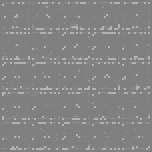

epoch: 3/300, batch: 10/891, G_loss: 10.408342361450195, D_loss: (0.0, 4.237297980580479e-05)
epoch: 3/300, batch: 20/891, G_loss: 10.499746322631836, D_loss: (0.0, 3.884052421199158e-05)
epoch: 3/300, batch: 30/891, G_loss: 10.456802368164062, D_loss: (0.0, 4.4331933167995885e-05)
epoch: 3/300, batch: 40/891, G_loss: 10.441144943237305, D_loss: (0.0, 4.879527841694653e-05)
epoch: 3/300, batch: 50/891, G_loss: 10.331552505493164, D_loss: (0.0, 4.355714554549195e-05)
epoch: 3/300, batch: 60/891, G_loss: 10.428268432617188, D_loss: (0.0, 3.6696044844575226e-05)
epoch: 3/300, batch: 70/891, G_loss: 10.442340850830078, D_loss: (0.0, 4.9206806579604745e-05)
epoch: 3/300, batch: 80/891, G_loss: 10.406198501586914, D_loss: (0.0, 4.4563363189809024e-05)
epoch: 3/300, batch: 90/891, G_loss: 10.650154113769531, D_loss: (0.0, 5.138561027706601e-05)
epoch: 3/300, batch: 100/891, G_loss: 10.38679313659668, D_loss: (0.0, 4.261815774952993e-05)


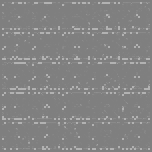

epoch: 3/300, batch: 110/891, G_loss: 10.573707580566406, D_loss: (0.0, 4.2675063014030457e-05)
epoch: 3/300, batch: 120/891, G_loss: 10.388664245605469, D_loss: (0.0, 4.711376823252067e-05)
epoch: 3/300, batch: 130/891, G_loss: 10.446924209594727, D_loss: (0.0, 3.049880797334481e-05)
epoch: 3/300, batch: 140/891, G_loss: 10.571134567260742, D_loss: (0.0, 3.158392428304069e-05)
epoch: 3/300, batch: 150/891, G_loss: 10.646492958068848, D_loss: (0.0, 2.971368667203933e-05)
epoch: 3/300, batch: 160/891, G_loss: 10.524497032165527, D_loss: (0.0, 3.869780630338937e-05)
epoch: 3/300, batch: 170/891, G_loss: 10.749507904052734, D_loss: (0.0, 2.328258051420562e-05)
epoch: 3/300, batch: 180/891, G_loss: 10.860679626464844, D_loss: (0.0, 3.333878703415394e-05)
epoch: 3/300, batch: 190/891, G_loss: 10.723633766174316, D_loss: (0.0, 3.998412285000086e-05)
epoch: 3/300, batch: 200/891, G_loss: 10.771604537963867, D_loss: (0.0, 2.828136166499462e-05)


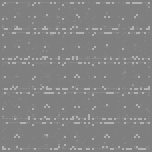

epoch: 3/300, batch: 210/891, G_loss: 10.693361282348633, D_loss: (0.0, 3.738192390301265e-05)
epoch: 3/300, batch: 220/891, G_loss: 10.841296195983887, D_loss: (0.0, 3.2918687793426216e-05)
epoch: 3/300, batch: 230/891, G_loss: 10.720254898071289, D_loss: (0.0, 3.714975173352286e-05)
epoch: 3/300, batch: 240/891, G_loss: 10.64233112335205, D_loss: (0.0, 2.970432979054749e-05)
epoch: 3/300, batch: 250/891, G_loss: 10.702201843261719, D_loss: (0.0, 3.8765225326642394e-05)
epoch: 3/300, batch: 260/891, G_loss: 10.578495025634766, D_loss: (0.0, 3.3175834687426686e-05)
epoch: 3/300, batch: 270/891, G_loss: 10.745216369628906, D_loss: (0.0, 3.657425259007141e-05)
epoch: 3/300, batch: 280/891, G_loss: 10.77140998840332, D_loss: (0.0, 3.123839996987954e-05)
epoch: 3/300, batch: 290/891, G_loss: 10.640340805053711, D_loss: (0.0, 3.507315705064684e-05)
epoch: 3/300, batch: 300/891, G_loss: 10.919817924499512, D_loss: (0.0, 2.5463792553637177e-05)


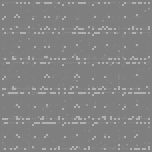

epoch: 3/300, batch: 310/891, G_loss: 10.827524185180664, D_loss: (0.0, 3.499130252748728e-05)
epoch: 3/300, batch: 320/891, G_loss: 10.897078514099121, D_loss: (0.0, 2.9510756576200947e-05)
epoch: 3/300, batch: 330/891, G_loss: 10.898694038391113, D_loss: (0.0, 3.0170962418196723e-05)
epoch: 3/300, batch: 340/891, G_loss: 10.79692268371582, D_loss: (0.0, 2.6541403713054024e-05)
epoch: 3/300, batch: 350/891, G_loss: 6.248892784118652, D_loss: (0.0, 0.00495539978146553)
epoch: 3/300, batch: 360/891, G_loss: 8.085306167602539, D_loss: (0.0, 0.00041594370850361884)
epoch: 3/300, batch: 370/891, G_loss: 8.49371337890625, D_loss: (0.0, 0.00034522032365202904)
epoch: 3/300, batch: 380/891, G_loss: 8.695591926574707, D_loss: (0.0, 0.00024497637059539557)
epoch: 3/300, batch: 390/891, G_loss: 9.079748153686523, D_loss: (0.0, 0.0001857050519902259)
epoch: 3/300, batch: 400/891, G_loss: 8.990118980407715, D_loss: (0.0, 0.00016701560525689274)


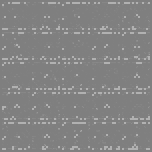

epoch: 3/300, batch: 410/891, G_loss: 9.437788963317871, D_loss: (0.0, 0.00015814951620995998)
epoch: 3/300, batch: 420/891, G_loss: 9.57960319519043, D_loss: (0.0, 0.00011637654824880883)
epoch: 3/300, batch: 430/891, G_loss: 9.379707336425781, D_loss: (0.0, 0.00011779602209571749)
epoch: 3/300, batch: 440/891, G_loss: 9.818018913269043, D_loss: (0.0, 0.00010461694182595238)
epoch: 3/300, batch: 450/891, G_loss: 9.94283390045166, D_loss: (0.0, 8.472360059386119e-05)
epoch: 3/300, batch: 460/891, G_loss: 9.681093215942383, D_loss: (0.0, 8.271458500530571e-05)
epoch: 3/300, batch: 470/891, G_loss: 9.672832489013672, D_loss: (0.0, 8.369826537091285e-05)
epoch: 3/300, batch: 480/891, G_loss: 9.932477951049805, D_loss: (0.0, 7.267292676260695e-05)
epoch: 3/300, batch: 490/891, G_loss: 9.915948867797852, D_loss: (0.0, 7.062003714963794e-05)
epoch: 3/300, batch: 500/891, G_loss: 10.170881271362305, D_loss: (0.0, 8.497931412421167e-05)


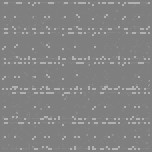

epoch: 3/300, batch: 510/891, G_loss: 10.026226997375488, D_loss: (0.0, 7.584214472444728e-05)
epoch: 3/300, batch: 520/891, G_loss: 9.981310844421387, D_loss: (0.0, 5.637341382680461e-05)
epoch: 3/300, batch: 530/891, G_loss: 10.306292533874512, D_loss: (0.0, 6.983728962950408e-05)
epoch: 3/300, batch: 540/891, G_loss: 10.219045639038086, D_loss: (0.0, 4.826590156881139e-05)
epoch: 3/300, batch: 550/891, G_loss: 10.341421127319336, D_loss: (0.0, 5.4044390708440915e-05)
epoch: 3/300, batch: 560/891, G_loss: 10.257444381713867, D_loss: (0.0, 5.9145902923773974e-05)
epoch: 3/300, batch: 570/891, G_loss: 10.05578899383545, D_loss: (0.0, 5.0911698053823784e-05)
epoch: 3/300, batch: 580/891, G_loss: 10.429096221923828, D_loss: (0.0, 4.929498027195223e-05)
epoch: 3/300, batch: 590/891, G_loss: 10.407175064086914, D_loss: (0.0, 5.737173341913149e-05)
epoch: 3/300, batch: 600/891, G_loss: 10.33273983001709, D_loss: (0.0, 4.671859642257914e-05)


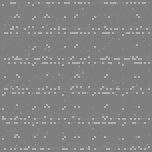

epoch: 3/300, batch: 610/891, G_loss: 10.425661087036133, D_loss: (0.0, 4.125277337152511e-05)
epoch: 3/300, batch: 620/891, G_loss: 10.590597152709961, D_loss: (0.0, 4.077875200891867e-05)
epoch: 3/300, batch: 630/891, G_loss: 10.515806198120117, D_loss: (0.0, 4.537343920674175e-05)
epoch: 3/300, batch: 640/891, G_loss: 10.589239120483398, D_loss: (0.0, 3.76133612007834e-05)
epoch: 3/300, batch: 650/891, G_loss: 10.62701416015625, D_loss: (0.0, 3.46470988006331e-05)
epoch: 3/300, batch: 660/891, G_loss: 10.644682884216309, D_loss: (0.0, 3.259742516092956e-05)
epoch: 3/300, batch: 670/891, G_loss: 10.684457778930664, D_loss: (0.0, 5.11858488607686e-05)
epoch: 3/300, batch: 680/891, G_loss: 10.683004379272461, D_loss: (0.0, 3.8421039789682254e-05)
epoch: 3/300, batch: 690/891, G_loss: 10.614120483398438, D_loss: (0.0, 3.455156911513768e-05)
epoch: 3/300, batch: 700/891, G_loss: 10.777164459228516, D_loss: (0.0, 3.561416087904945e-05)


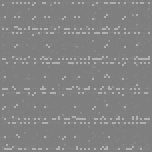

epoch: 3/300, batch: 710/891, G_loss: 10.652826309204102, D_loss: (0.0, 3.448655115789734e-05)
epoch: 3/300, batch: 720/891, G_loss: 10.877477645874023, D_loss: (0.0, 3.403473601792939e-05)
epoch: 3/300, batch: 730/891, G_loss: 10.634112358093262, D_loss: (0.0, 4.263081791577861e-05)
epoch: 3/300, batch: 740/891, G_loss: 11.029352188110352, D_loss: (0.0, 3.0915434763301164e-05)
epoch: 3/300, batch: 750/891, G_loss: 10.824968338012695, D_loss: (0.0, 3.6261895729694515e-05)
epoch: 3/300, batch: 760/891, G_loss: 10.863007545471191, D_loss: (0.0, 2.7077910999651067e-05)
epoch: 3/300, batch: 770/891, G_loss: 11.038161277770996, D_loss: (0.0, 2.635331838973798e-05)
epoch: 3/300, batch: 780/891, G_loss: 10.966436386108398, D_loss: (0.0, 1.962515671039e-05)
epoch: 3/300, batch: 790/891, G_loss: 11.223081588745117, D_loss: (0.0, 3.335100700496696e-05)
epoch: 3/300, batch: 800/891, G_loss: 11.07284164428711, D_loss: (0.0, 2.7123738618684e-05)


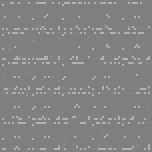

epoch: 3/300, batch: 810/891, G_loss: 11.129776954650879, D_loss: (0.0, 1.900214556371793e-05)
epoch: 3/300, batch: 820/891, G_loss: 10.971302032470703, D_loss: (0.0, 2.185577068303246e-05)
epoch: 3/300, batch: 830/891, G_loss: 11.01913833618164, D_loss: (0.0, 1.782674007699825e-05)
epoch: 3/300, batch: 840/891, G_loss: 11.03027057647705, D_loss: (0.0, 2.702038545976393e-05)
epoch: 3/300, batch: 850/891, G_loss: 11.27177619934082, D_loss: (0.0, 2.249753561045509e-05)
epoch: 3/300, batch: 860/891, G_loss: 10.905803680419922, D_loss: (0.0, 2.3645949113415554e-05)
epoch: 3/300, batch: 870/891, G_loss: 11.208195686340332, D_loss: (0.0, 1.9946470274589956e-05)
epoch: 3/300, batch: 880/891, G_loss: 11.20502758026123, D_loss: (0.0, 2.254799983347766e-05)
epoch: 3/300, batch: 890/891, G_loss: 11.256278991699219, D_loss: (0.0, 2.8371203370625153e-05)
epoch: 4/300, batch: 0/891, G_loss: 11.285905838012695, D_loss: (0.0, 2.2354286556947045e-05)


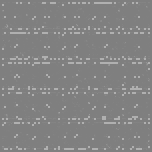

epoch: 4/300, batch: 10/891, G_loss: 11.142900466918945, D_loss: (0.0, 2.2886062652105466e-05)
epoch: 4/300, batch: 20/891, G_loss: 11.233553886413574, D_loss: (0.0, 2.2181906388141215e-05)
epoch: 4/300, batch: 30/891, G_loss: 11.391706466674805, D_loss: (0.0, 1.9093458831775934e-05)
epoch: 4/300, batch: 40/891, G_loss: 11.230469703674316, D_loss: (0.0, 1.808471279218793e-05)
epoch: 4/300, batch: 50/891, G_loss: 11.322175979614258, D_loss: (0.0, 2.5372439267812297e-05)
epoch: 4/300, batch: 60/891, G_loss: 11.336390495300293, D_loss: (0.0, 2.3165579477790743e-05)
epoch: 4/300, batch: 70/891, G_loss: 11.215435028076172, D_loss: (0.0, 1.6261201380984858e-05)
epoch: 4/300, batch: 80/891, G_loss: 11.366328239440918, D_loss: (0.0, 2.0507372028077953e-05)
epoch: 4/300, batch: 90/891, G_loss: 11.418668746948242, D_loss: (0.0, 1.9391423847991973e-05)
epoch: 4/300, batch: 100/891, G_loss: 11.46181869506836, D_loss: (0.0, 1.666814750933554e-05)


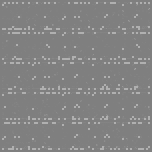

epoch: 4/300, batch: 110/891, G_loss: 11.499885559082031, D_loss: (0.0, 1.951822378032375e-05)
epoch: 4/300, batch: 120/891, G_loss: 11.469321250915527, D_loss: (0.0, 1.7617201592656784e-05)
epoch: 4/300, batch: 130/891, G_loss: 11.506845474243164, D_loss: (0.0, 1.91401231859345e-05)
epoch: 4/300, batch: 140/891, G_loss: 11.471517562866211, D_loss: (0.0, 1.4298821042757481e-05)
epoch: 4/300, batch: 150/891, G_loss: 11.628559112548828, D_loss: (0.0, 1.9296650862088427e-05)
epoch: 4/300, batch: 160/891, G_loss: 11.541261672973633, D_loss: (0.0, 1.5986366634024307e-05)
epoch: 4/300, batch: 170/891, G_loss: 11.620824813842773, D_loss: (0.0, 1.6275291272904724e-05)
epoch: 4/300, batch: 180/891, G_loss: 11.370805740356445, D_loss: (0.0, 1.62519900186453e-05)
epoch: 4/300, batch: 190/891, G_loss: 11.643312454223633, D_loss: (0.0, 1.7092022972065024e-05)
epoch: 4/300, batch: 200/891, G_loss: 11.612682342529297, D_loss: (0.0, 1.5272977179847658e-05)


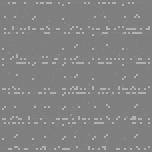

epoch: 4/300, batch: 210/891, G_loss: 11.594510078430176, D_loss: (0.0, 1.4844581528450362e-05)
epoch: 4/300, batch: 220/891, G_loss: 11.830224990844727, D_loss: (0.0, 1.9478331523714587e-05)
epoch: 4/300, batch: 230/891, G_loss: 11.745172500610352, D_loss: (0.0, 1.9790162696153857e-05)
epoch: 4/300, batch: 240/891, G_loss: 11.50505256652832, D_loss: (0.0, 1.3742776900471654e-05)
epoch: 4/300, batch: 250/891, G_loss: 11.59770679473877, D_loss: (0.0, 1.229918962053489e-05)
epoch: 4/300, batch: 260/891, G_loss: 11.494617462158203, D_loss: (0.0, 1.380337471346138e-05)
epoch: 4/300, batch: 270/891, G_loss: 11.757104873657227, D_loss: (0.0, 1.1938838724745438e-05)
epoch: 4/300, batch: 280/891, G_loss: 11.800178527832031, D_loss: (0.0, 1.4947075214877259e-05)
epoch: 4/300, batch: 290/891, G_loss: 11.821983337402344, D_loss: (0.0, 1.2075682207068894e-05)
epoch: 4/300, batch: 300/891, G_loss: 11.695706367492676, D_loss: (0.0, 1.2038410204695538e-05)


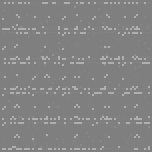

epoch: 4/300, batch: 310/891, G_loss: 11.618280410766602, D_loss: (0.0, 1.349055310129188e-05)
epoch: 4/300, batch: 320/891, G_loss: 11.784629821777344, D_loss: (0.0, 9.603882062947378e-06)
epoch: 4/300, batch: 330/891, G_loss: 11.688289642333984, D_loss: (0.0, 1.2908312783110887e-05)
epoch: 4/300, batch: 340/891, G_loss: 11.78610610961914, D_loss: (0.0, 1.7276619473705068e-05)
epoch: 4/300, batch: 350/891, G_loss: 11.688333511352539, D_loss: (0.0, 1.1215093763894401e-05)
epoch: 4/300, batch: 360/891, G_loss: 11.858537673950195, D_loss: (0.0, 1.416038958268473e-05)
epoch: 4/300, batch: 370/891, G_loss: 11.792045593261719, D_loss: (0.0, 1.2824513760278933e-05)
epoch: 4/300, batch: 380/891, G_loss: 11.98605728149414, D_loss: (0.0, 1.1769302545872051e-05)
epoch: 4/300, batch: 390/891, G_loss: 11.547867774963379, D_loss: (0.0, 1.352675008092774e-05)
epoch: 4/300, batch: 400/891, G_loss: 11.882970809936523, D_loss: (0.0, 1.095154948416166e-05)


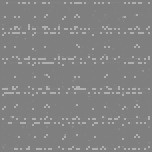

epoch: 4/300, batch: 410/891, G_loss: 11.754509925842285, D_loss: (0.0, 1.6195444914046675e-05)
epoch: 4/300, batch: 420/891, G_loss: 11.973133087158203, D_loss: (0.0, 1.365346361126285e-05)
epoch: 4/300, batch: 430/891, G_loss: 11.685393333435059, D_loss: (0.0, 1.0861180271604098e-05)
epoch: 4/300, batch: 440/891, G_loss: 11.841516494750977, D_loss: (0.0, 1.2599101864907425e-05)
epoch: 4/300, batch: 450/891, G_loss: 11.976505279541016, D_loss: (0.0, 1.2031895494146738e-05)
epoch: 4/300, batch: 460/891, G_loss: 11.835779190063477, D_loss: (0.0, 8.947313290263992e-06)
epoch: 4/300, batch: 470/891, G_loss: 11.929258346557617, D_loss: (0.0, 1.234393312188331e-05)
epoch: 4/300, batch: 480/891, G_loss: 11.811162948608398, D_loss: (0.0, 1.081928530766163e-05)
epoch: 4/300, batch: 490/891, G_loss: 12.087151527404785, D_loss: (0.0, 1.0129173460882157e-05)
epoch: 4/300, batch: 500/891, G_loss: 12.041516304016113, D_loss: (0.0, 1.1604528481257148e-05)


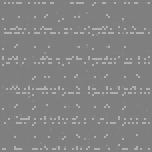

epoch: 4/300, batch: 510/891, G_loss: 11.92258071899414, D_loss: (0.0, 1.3150644008419476e-05)
epoch: 4/300, batch: 520/891, G_loss: 12.048938751220703, D_loss: (0.0, 1.1053165508201346e-05)
epoch: 4/300, batch: 530/891, G_loss: 11.9271240234375, D_loss: (0.0, 1.0900303095695563e-05)
epoch: 4/300, batch: 540/891, G_loss: 11.814849853515625, D_loss: (0.0, 9.867482731351629e-06)
epoch: 4/300, batch: 550/891, G_loss: 12.177257537841797, D_loss: (0.0, 8.8131710072048e-06)
epoch: 4/300, batch: 560/891, G_loss: 12.054560661315918, D_loss: (0.0, 8.202226126741152e-06)
epoch: 4/300, batch: 570/891, G_loss: 12.235161781311035, D_loss: (0.0, 6.482971912191715e-06)
epoch: 4/300, batch: 580/891, G_loss: 12.044758796691895, D_loss: (0.0, 9.706323908176273e-06)
epoch: 4/300, batch: 590/891, G_loss: 11.939733505249023, D_loss: (0.0, 9.214591045747511e-06)
epoch: 4/300, batch: 600/891, G_loss: 12.189058303833008, D_loss: (0.0, 7.874395123508293e-06)


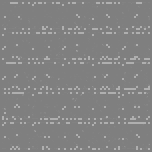

epoch: 4/300, batch: 610/891, G_loss: 12.302862167358398, D_loss: (0.0, 1.0150661182706244e-05)
epoch: 4/300, batch: 620/891, G_loss: 11.926076889038086, D_loss: (0.0, 7.611768523929641e-06)
epoch: 4/300, batch: 630/891, G_loss: 12.132942199707031, D_loss: (0.0, 7.765442205709405e-06)
epoch: 4/300, batch: 640/891, G_loss: 12.223628997802734, D_loss: (0.0, 8.667899237480015e-06)
epoch: 4/300, batch: 650/891, G_loss: 12.439538955688477, D_loss: (0.0, 6.930943527549971e-06)
epoch: 4/300, batch: 660/891, G_loss: 12.068002700805664, D_loss: (0.0, 9.071238309843466e-06)
epoch: 4/300, batch: 670/891, G_loss: 12.165964126586914, D_loss: (0.0, 9.390633749717381e-06)
epoch: 4/300, batch: 680/891, G_loss: 12.177215576171875, D_loss: (0.0, 9.094492270378396e-06)
epoch: 4/300, batch: 690/891, G_loss: 12.131624221801758, D_loss: (0.0, 8.345652531716041e-06)
epoch: 4/300, batch: 700/891, G_loss: 11.933269500732422, D_loss: (0.0, 9.771548320713919e-06)


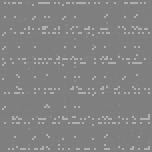

epoch: 4/300, batch: 710/891, G_loss: 12.150323867797852, D_loss: (0.0, 8.500255717081018e-06)
epoch: 4/300, batch: 720/891, G_loss: 12.3328218460083, D_loss: (0.0, 8.669752787682228e-06)
epoch: 4/300, batch: 730/891, G_loss: 12.290023803710938, D_loss: (0.0, 7.762631867080927e-06)
epoch: 4/300, batch: 740/891, G_loss: 12.130565643310547, D_loss: (0.0, 8.71076736075338e-06)
epoch: 4/300, batch: 750/891, G_loss: 12.375385284423828, D_loss: (0.0, 6.88065483700484e-06)
epoch: 4/300, batch: 760/891, G_loss: 12.440778732299805, D_loss: (0.0, 8.487246304866858e-06)
epoch: 4/300, batch: 770/891, G_loss: 12.130022048950195, D_loss: (0.0, 8.539359441783745e-06)
epoch: 4/300, batch: 780/891, G_loss: 12.269145965576172, D_loss: (0.0, 7.081817784637678e-06)
epoch: 4/300, batch: 790/891, G_loss: 12.43948745727539, D_loss: (0.0, 6.7046485128230415e-06)
epoch: 4/300, batch: 800/891, G_loss: 12.32712173461914, D_loss: (0.0, 8.083014108706266e-06)


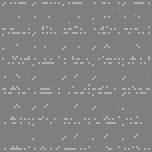

epoch: 4/300, batch: 810/891, G_loss: 12.439067840576172, D_loss: (0.0, 7.396621185762342e-06)
epoch: 4/300, batch: 820/891, G_loss: 12.43800163269043, D_loss: (0.0, 7.078131147864042e-06)
epoch: 4/300, batch: 830/891, G_loss: 12.321148872375488, D_loss: (0.0, 7.726326657575555e-06)
epoch: 4/300, batch: 840/891, G_loss: 12.429605484008789, D_loss: (0.0, 6.745619884895859e-06)
epoch: 4/300, batch: 850/891, G_loss: 12.287752151489258, D_loss: (0.0, 8.164064638549462e-06)
epoch: 4/300, batch: 860/891, G_loss: 12.20138931274414, D_loss: (0.0, 6.9477273427764885e-06)
epoch: 4/300, batch: 870/891, G_loss: 12.304052352905273, D_loss: (0.0, 9.706369382911362e-06)
epoch: 4/300, batch: 880/891, G_loss: 12.190162658691406, D_loss: (0.0, 7.279272722371388e-06)
epoch: 4/300, batch: 890/891, G_loss: 12.617685317993164, D_loss: (0.0, 8.821683877613395e-06)
epoch: 5/300, batch: 0/891, G_loss: 12.246307373046875, D_loss: (0.0, 8.076520316535607e-06)


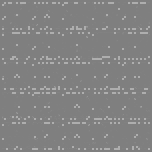

epoch: 5/300, batch: 10/891, G_loss: 12.36683177947998, D_loss: (0.0, 5.707173841074109e-06)
epoch: 5/300, batch: 20/891, G_loss: 12.393516540527344, D_loss: (0.0, 5.6214985306723975e-06)
epoch: 5/300, batch: 30/891, G_loss: 12.45411491394043, D_loss: (0.0, 5.6904218581621535e-06)
epoch: 5/300, batch: 40/891, G_loss: 12.424982070922852, D_loss: (0.0, 5.260135822027223e-06)
epoch: 5/300, batch: 50/891, G_loss: 12.17293930053711, D_loss: (0.0, 6.567728632944636e-06)
epoch: 5/300, batch: 60/891, G_loss: 12.597246170043945, D_loss: (0.0, 6.89651096763555e-06)
epoch: 5/300, batch: 70/891, G_loss: 12.391571044921875, D_loss: (0.0, 8.023419468372595e-06)
epoch: 5/300, batch: 80/891, G_loss: 12.684584617614746, D_loss: (0.0, 6.421517355192918e-06)
epoch: 5/300, batch: 90/891, G_loss: 12.384993553161621, D_loss: (0.0, 6.446658517234027e-06)
epoch: 5/300, batch: 100/891, G_loss: 12.43918514251709, D_loss: (0.0, 6.229661266843323e-06)


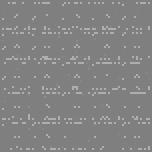

epoch: 5/300, batch: 110/891, G_loss: 12.63405990600586, D_loss: (0.0, 8.825346412777435e-06)
epoch: 5/300, batch: 120/891, G_loss: 12.933784484863281, D_loss: (0.0, 5.804976353829261e-06)
epoch: 5/300, batch: 130/891, G_loss: 12.367731094360352, D_loss: (0.0, 4.895056918030605e-06)
epoch: 5/300, batch: 140/891, G_loss: 12.648581504821777, D_loss: (0.0, 5.681099537468981e-06)
epoch: 5/300, batch: 150/891, G_loss: 12.722955703735352, D_loss: (0.0, 8.247900041169487e-06)
epoch: 5/300, batch: 160/891, G_loss: 12.553330421447754, D_loss: (0.0, 6.503467375296168e-06)
epoch: 5/300, batch: 170/891, G_loss: 12.753960609436035, D_loss: (0.0, 5.397043423727155e-06)
epoch: 5/300, batch: 180/891, G_loss: 12.702919006347656, D_loss: (0.0, 5.742565008404199e-06)
epoch: 5/300, batch: 190/891, G_loss: 12.526922225952148, D_loss: (0.0, 4.976086074748309e-06)
epoch: 5/300, batch: 200/891, G_loss: 12.481029510498047, D_loss: (0.0, 4.950012225890532e-06)


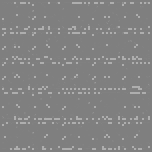

epoch: 5/300, batch: 210/891, G_loss: 12.339339256286621, D_loss: (0.0, 6.858321739855455e-06)
epoch: 5/300, batch: 220/891, G_loss: 12.693550109863281, D_loss: (0.0, 6.568670869455673e-06)
epoch: 5/300, batch: 230/891, G_loss: 12.407625198364258, D_loss: (0.0, 4.7143794290605e-06)
epoch: 5/300, batch: 240/891, G_loss: 12.53386116027832, D_loss: (0.0, 5.5702785175526515e-06)
epoch: 5/300, batch: 250/891, G_loss: 12.511159896850586, D_loss: (0.0, 5.91486877965508e-06)
epoch: 5/300, batch: 260/891, G_loss: 12.48033332824707, D_loss: (0.0, 6.222205229278188e-06)
epoch: 5/300, batch: 270/891, G_loss: 12.67634391784668, D_loss: (0.0, 6.2213025557866786e-06)
epoch: 5/300, batch: 280/891, G_loss: 12.567431449890137, D_loss: (0.0, 5.477141712617595e-06)
epoch: 5/300, batch: 290/891, G_loss: 12.542274475097656, D_loss: (0.0, 3.991663106717169e-06)
epoch: 5/300, batch: 300/891, G_loss: 12.532949447631836, D_loss: (0.0, 5.723018148273695e-06)


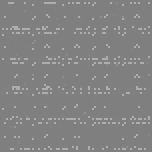

epoch: 5/300, batch: 310/891, G_loss: 12.529386520385742, D_loss: (0.0, 5.4100855777505785e-06)
epoch: 5/300, batch: 320/891, G_loss: 12.68446159362793, D_loss: (0.0, 6.6869852162199095e-06)
epoch: 5/300, batch: 330/891, G_loss: 12.718401908874512, D_loss: (0.0, 4.534633262665011e-06)
epoch: 5/300, batch: 340/891, G_loss: 12.787392616271973, D_loss: (0.0, 5.6838971431716345e-06)
epoch: 5/300, batch: 350/891, G_loss: 12.532411575317383, D_loss: (0.0, 5.606611466646427e-06)
epoch: 5/300, batch: 360/891, G_loss: 12.719876289367676, D_loss: (0.0, 5.856195457454305e-06)
epoch: 5/300, batch: 370/891, G_loss: 12.783262252807617, D_loss: (0.0, 5.617788701783866e-06)
epoch: 5/300, batch: 380/891, G_loss: 12.64208984375, D_loss: (0.0, 5.243387477094075e-06)
epoch: 5/300, batch: 390/891, G_loss: 12.932731628417969, D_loss: (0.0, 4.936040568281896e-06)
epoch: 5/300, batch: 400/891, G_loss: 12.700695991516113, D_loss: (0.0, 5.198667167860549e-06)


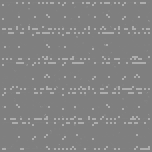

epoch: 5/300, batch: 410/891, G_loss: 12.929733276367188, D_loss: (0.0, 3.885492787958356e-06)
epoch: 5/300, batch: 420/891, G_loss: 12.959094047546387, D_loss: (0.0, 4.323215307522332e-06)
epoch: 5/300, batch: 430/891, G_loss: 12.849960327148438, D_loss: (0.0, 4.494595941650914e-06)
epoch: 5/300, batch: 440/891, G_loss: 12.926616668701172, D_loss: (0.0, 5.804989541502437e-06)
epoch: 5/300, batch: 450/891, G_loss: 12.789581298828125, D_loss: (0.0, 4.9481441237730905e-06)
epoch: 5/300, batch: 460/891, G_loss: 13.029966354370117, D_loss: (0.0, 6.077869329601526e-06)
epoch: 5/300, batch: 470/891, G_loss: 12.98122501373291, D_loss: (0.0, 4.230085323797539e-06)
epoch: 5/300, batch: 480/891, G_loss: 12.964428901672363, D_loss: (0.0, 5.2322056944831274e-06)
epoch: 5/300, batch: 490/891, G_loss: 12.927703857421875, D_loss: (0.0, 3.412378646316938e-06)
epoch: 5/300, batch: 500/891, G_loss: 12.543306350708008, D_loss: (0.0, 5.386795237427577e-06)


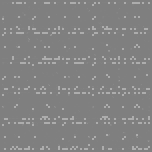

epoch: 5/300, batch: 510/891, G_loss: 12.955595016479492, D_loss: (0.0, 4.215185526845744e-06)
epoch: 5/300, batch: 520/891, G_loss: 12.925934791564941, D_loss: (0.0, 4.399589670356363e-06)
epoch: 5/300, batch: 530/891, G_loss: 12.94444465637207, D_loss: (0.0, 6.094685886637308e-06)
epoch: 5/300, batch: 540/891, G_loss: 12.838550567626953, D_loss: (0.0, 3.336009285703767e-06)
epoch: 5/300, batch: 550/891, G_loss: 12.872605323791504, D_loss: (0.0, 5.464103651320329e-06)
epoch: 5/300, batch: 560/891, G_loss: 12.706819534301758, D_loss: (0.0, 3.6806086427532136e-06)
epoch: 5/300, batch: 570/891, G_loss: 12.87987995147705, D_loss: (0.0, 4.9369696171197575e-06)
epoch: 5/300, batch: 580/891, G_loss: 13.13755989074707, D_loss: (0.0, 3.042641537831514e-06)
epoch: 5/300, batch: 590/891, G_loss: 12.725643157958984, D_loss: (0.0, 6.374043096002424e-06)
epoch: 5/300, batch: 600/891, G_loss: 12.894926071166992, D_loss: (0.0, 3.373259460204281e-06)


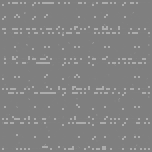

epoch: 5/300, batch: 610/891, G_loss: 12.932633399963379, D_loss: (0.0, 4.13789121012087e-06)
epoch: 5/300, batch: 620/891, G_loss: 12.842475891113281, D_loss: (0.0, 4.2775859583343845e-06)
epoch: 5/300, batch: 630/891, G_loss: 12.96400260925293, D_loss: (0.0, 4.706933395937085e-06)
epoch: 5/300, batch: 640/891, G_loss: 12.927469253540039, D_loss: (0.0, 4.412627731653629e-06)
epoch: 5/300, batch: 650/891, G_loss: 12.985258102416992, D_loss: (0.0, 5.163297373655951e-06)
epoch: 5/300, batch: 660/891, G_loss: 12.968954086303711, D_loss: (0.0, 4.065244866069406e-06)
epoch: 5/300, batch: 670/891, G_loss: 12.980001449584961, D_loss: (0.0, 3.619135213739355e-06)
epoch: 5/300, batch: 680/891, G_loss: 13.056255340576172, D_loss: (0.0, 3.6433475543162785e-06)
epoch: 5/300, batch: 690/891, G_loss: 13.1406831741333, D_loss: (0.0, 4.278514097677544e-06)
epoch: 5/300, batch: 700/891, G_loss: 12.984804153442383, D_loss: (0.0, 3.5884036151401233e-06)


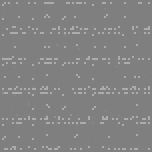

epoch: 5/300, batch: 710/891, G_loss: 12.939826011657715, D_loss: (0.0, 4.395863470563199e-06)
epoch: 5/300, batch: 720/891, G_loss: 12.872212409973145, D_loss: (0.0, 3.8705975384800695e-06)
epoch: 5/300, batch: 730/891, G_loss: 12.932330131530762, D_loss: (0.0, 4.900662133877631e-06)
epoch: 5/300, batch: 740/891, G_loss: 13.01910400390625, D_loss: (0.0, 3.7765264551126165e-06)
epoch: 5/300, batch: 750/891, G_loss: 13.097492218017578, D_loss: (0.0, 3.3555656955286395e-06)
epoch: 5/300, batch: 760/891, G_loss: 13.067063331604004, D_loss: (0.0, 2.8926963295816677e-06)
epoch: 5/300, batch: 770/891, G_loss: 13.198843002319336, D_loss: (0.0, 4.1546509237377904e-06)
epoch: 5/300, batch: 780/891, G_loss: 12.829179763793945, D_loss: (0.0, 4.221715244057123e-06)


KeyboardInterrupt: ignored

In [163]:
for epoch in range(num_epochs):
  
    # Train epoch
    for n_batch, (real_samples,_) in enumerate(train_loader):
        
        # Prepare batch data
        real_samples = Variable(real_samples).cuda()
          
        # Update model weights
        if real_samples.size(0) == 64:
          loss_g, loss_d = model.step_optimization(real_samples)
        
        # Show current loss
        if (n_batch) % 10 == 0:
            print(f"epoch: {epoch}/{num_epochs}, batch: {n_batch}/{len(train_loader)}, G_loss: {loss_g}, D_loss: {loss_d}")    
          
        # Show fake samples
        if (n_batch) % 100 == 0:
            val_fake_samples = model.generate_samples(num_val_samples, z=z_val).data.cpu()
            display_batch_images(val_fake_samples)